# Solar Power Forecasting Using Vector Auto Regression

1. Read labeled data from output.xlsx
2. Set forecast_days
3. Generate probabilistic labels
4. Run VAR

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [2]:
import datetime

In [3]:
forecast_days = 7

In [4]:
xls = pd.ExcelFile("output.xlsx")

In [5]:
years = ["2013","2014","2015","2016","2017","2018","2019","2020","2021"]

In [6]:
df_obj = dict()
for i in years:
    df_obj[i] = pd.read_excel(xls, i)
    df_obj[i] = df_obj[i].drop(["Unnamed: 0"],axis=True)

## Forecasting start

In [7]:
df = df_obj['2013']
# df = df.append(df_obj['2016'])
for i in range(2014,2022):
    df = df.append(df_obj[str(i)])
    
df1 = df.drop([
#                     "1104500527", "1104500529", "1.104501e+09", "7802195.0", "2100570073/ 2100567820/ 2100567898", 
#                     "Aggregate Meter Reading (KWH)", 
#                     "Difference", "SEEDs data (KWH)", "Insolation", 
                    "PR (%)", "Any Issues/Problems Observed", "WO#", "NO-OFF-CLEAN MODULES"], axis=1)

In [8]:
df1

Date  1104500527  1104500529  1.104501e+09  7802195.0  \
0   2013-01-01       955.0      1001.0         950.0      922.0   
1   2013-01-02      1108.0      1159.0        1096.0     1113.0   
2   2013-01-03      1058.0      1102.0        1091.0     1045.0   
3   2013-01-04      1091.0      1154.0        1188.0     1092.0   
4   2013-01-05      1125.0      1232.0        1226.0     1132.0   
..         ...         ...         ...           ...        ...   
215 2021-08-04       388.0       509.0         514.0      620.0   
216 2021-08-05       479.0       659.0         645.0      791.0   
217 2021-08-06       479.0       641.0         615.0      751.0   
218 2021-08-07       483.0       655.0         640.0      771.0   
219 2021-08-08       530.0       756.0         736.0      867.0   

     2100570073/ 2100567820/ 2100567898  Total Generation (KWH)  \
0                                  8.34                 3836.34   
1                                 14.52                 4490.52   
2                                 10.98                 4306.98   
3                                 10.99                 4535.99   
4                                 16.34                 4731.34   
..                                  ...                     ...   
215                               21.94                 2052.94   
216                               31.47                 2605.47   
217                               29.78                 2515.78   
218                               29.53                 2578.53   
219                               34.18                 2923.18   

     Aggregate Meter Reading (KWH)  Difference  SEEDs data (KWH)  ...  \
0                          3735.00      101.34            3893.0  ...   
1                          4380.00      110.52            4540.0  ...   
2                          4200.00      106.98            4356.0  ...   
3                          4395.00      140.99            4585.0  ...   
4                          4590.00      141.34            4773.0  ...   
..                             ...         ...               ...  ...   
215                        1903.50      149.44            2053.0  ...   
216                        2467.50      137.97            2606.0  ...   
217                        2346.00      169.78            2516.0  ...   
218                        2419.50      159.03            2579.0  ...   
219                        2744.25      178.93            2859.0  ...   

     Module Cleaning  Rainy day  No Module Cleaning  \
0                  0          0                   0   
1                  0          0                   0   
2                  0          0                   0   
3                  0          0                   0   
4                  0          0                   0   
..               ...        ...                 ...   
215                0          0                   0   
216                1          0                   0   
217                1          0                   0   
218                1          0                   0   
219                0          0                   0   

     Transformer replacement and maintenance  Cable and Fuse maintenance  \
0                                          0                           0   
1                                          0                           0   
2                                          0                           0   
3                                          0                           0   
4                                          0                           0   
..                                       ...                         ...   
215                                        0                           0   
216                                        0                           0   
217                                        0                           0   
218                                        0                           0   
219                       

In [9]:
for year in years:
    df_obj[year]['Date'] = pd.to_datetime(df_obj[year]['Date'])

In [10]:
for year in years:
    df_obj[year]["2100570073/ 2100567820/ 2100567898"] = pd.to_numeric(df_obj[year]["2100570073/ 2100567820/ 2100567898"])

## MEAN, PROBABILITY

In [11]:
maxlag=8
test = 'ssr_chi2test'
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [12]:
df1.columns

Index(['Date', '1104500527', '1104500529', '1.104501e+09', '7802195.0',
       '2100570073/ 2100567820/ 2100567898', 'Total Generation (KWH)',
       'Aggregate Meter Reading (KWH)', 'Difference', 'SEEDs data (KWH)',
       'Insolation', 'Grid Failure', 'Inverter', 'Module Cleaning',
       'Rainy day', 'No Module Cleaning',
       'Transformer replacement and maintenance', 'Cable and Fuse maintenance',
       'Plant Shutdown', 'Internet', 'Battery', 'Cloudy',
       'Module Cleaning by rains'],
      dtype='object')

In [13]:
cas_var = ["1104500527", "1104500529", "1.104501e+09", "7802195.0", 
           "2100570073/ 2100567820/ 2100567898", 
           "Total Generation (KWH)",
           "Insolation",
           'Grid Failure', 'Inverter', 'Module Cleaning',
           'Rainy day', 'Cloudy',
#            'Transformer replacement and maintenance', 'Cable and Fuse maintenance',
           'Plant Shutdown', 'Internet', 'Battery'
#            'Module Cleaning by rains'
          ]

In [14]:
for i in cas_var:
    df1[i] = df1[i].fillna(0)
    print(i, df1[i].isna().sum())

1104500527 0
1104500529 0
1.104501e+09 0
7802195.0 0
2100570073/ 2100567820/ 2100567898 0
Total Generation (KWH) 0
Insolation 0
Grid Failure 0
Inverter 0
Module Cleaning 0
Rainy day 0
Cloudy 0
Plant Shutdown 0
Internet 0
Battery 0


In [15]:
grangers_causation_matrix(df1, variables = cas_var)

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 2
  warnings.warn('covariance of constraints does not have full '


1104500527_x  1104500529_x  \
1104500527_y                                1.0000        0.0000   
1104500529_y                                0.1061        1.0000   
1.104501e+09_y                              0.0017        0.0004   
7802195.0_y                                 0.0000        0.0000   
2100570073/ 2100567820/ 2100567898_y        0.0000        0.0000   
Total Generation (KWH)_y                    0.0905        0.0036   
Insolation_y                                0.0922        0.1151   
Grid Failure_y                              0.0187        0.0044   
Inverter_y                                  0.0000        0.0000   
Module Cleaning_y                           0.0000        0.0000   
Rainy day_y                                 0.0109        0.0012   
Cloudy_y                                    0.0000        0.0000   
Plant Shutdown_y                            0.2845        0.4891   
Internet_y                                  0.0005        0.0374   
Battery_y                                   0.0228        0.0179   

                                      1.104501e+09_x  7802195.0_x  \
1104500527_y                                  0.0000       0.0000   
1104500529_y                                  0.0134       0.7044   
1.104501e+09_y                                1.0000       0.1660   
7802195.0_y                                   0.0000       1.0000   
2100570073/ 2100567820/ 2100567898_y          0.0000       0.0000   
Total Generation (KWH)_y                      0.0000       0.0260   
Insolation_y                                  0.0086       0.2455   
Grid Failure_y                                0.0090       0.0000   
Inverter_y                                    0.0000       0.0000   
Module Cleaning_y                             0.0000       0.0000   
Rainy day_y                                   0.0004       0.0001   
Cloudy_y                                      0.0000       0.0000   
Plant Shutdown_y                              0.4792       0.6343   
Internet_y                                    0.0686       0.1541   
Battery_y                                     0.0350       0.1559   

                                      2100570073/ 2100567820/ 2100567898_x  \
1104500527_y                                                        0.0000   
1104500529_y                                                        0.0480   
1.104501e+09_y                                                      0.4920   
7802195.0_y                                                         0.0012   
2100570073/ 2100567820/ 2100567898_y                                1.0000   
Total Generation (KWH)_y                                            0.1926   
Insolation_y                                                        0.2309   
Grid Failure_y                                                      0.0000   
Inverter_y                                                          0.0000   
Module Cleaning_y                                                   0.0000   
Rainy day_y                                                         0.0328   
Cloudy_y                                                            0.0007   
Plant Shutdown_y                                                    0.1833   
Internet_y                                                          0.0001   
Battery_y                                                           0.6038   

                                      Total Generation (KWH)_x  Insolation_x  \
1104500527_y                                            0.0000        0.0989   
1104500529_y                                            0.1954        0.0979   
1.104501e+09_y                                          0.0087        0.2202   
7802195.0_y                                             0.0000        0.2370   
2100570073/ 2100567820/ 2100567898_y                    0.0000        0.4626   
Total Generation (KWH)_y                                1.0000        0.2062   
Insolation_y                       

In [16]:
modules = ["1104500527", "1104500529", "1.104501e+09", "7802195.0", "2100570073/ 2100567820/ 2100567898"]

In [17]:
month_list = []
dict_mean = {}
mean_per_months = {}
for year in years:
#     dict_mean[year] = mean_per_months
    for module in modules:
        mean_per_months[module] = []
    dict_mean[year] = mean_per_months

In [18]:
dict_mean['2013']['1104500527']

[]

In [19]:
years

['2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021']

In [20]:
months = df_obj[years[1]]['Date'].dt.to_period('m')
for month, data_month in df_obj[years[1]].groupby(months):
    print(data_month)

         Date  1104500527  1104500529  1.104501e+09  7802195.0  \
0  2014-01-01       695.0       712.0         689.0      676.0   
1  2014-01-02       470.0       492.0         498.0      465.0   
2  2014-01-03       893.0       927.0         944.0      896.0   
3  2014-01-04       910.0       956.0         972.0      912.0   
4  2014-01-05      1119.0      1198.0        1199.0     1124.0   
5  2014-01-06      1165.0      1250.0        1238.0     1164.0   
6  2014-01-07      1136.0      1260.0        1204.0     1146.0   
7  2014-01-08      1007.0      1080.0        1035.0      952.0   
8  2014-01-09      1046.0      1097.0        1045.0      979.0   
9  2014-01-10      1023.0      1046.0        1018.0      914.0   
10 2014-01-11       871.0       899.0         859.0      772.0   
11 2014-01-12      1102.0      1147.0        1097.0     1026.0   
12 2014-01-13       995.0      1035.0         995.0      883.0   
13 2014-01-14      1006.0      1046.0        1006.0      969.0   
14 2014-01

In [21]:
count = 0
month_list = []
dict_mean = {}
mean_per_months = {}
for year in years:
#     dict_mean[year] = mean_per_months
    for module in modules:
        mean_per_months[module] = []
    dict_mean[year] = mean_per_months
for year in years:
    months = df_obj[year]['Date'].dt.to_period('m')
    temp_module_list = dict()
    for module in modules:
        temp_module_list[module] = []
    for month, data_month in df_obj[year].groupby(months):  
        month_list.append(str(month))
        for module in modules:
#             temp_module_list[module] = []
            temp_mean = data_month[module].mean()
            temp_module_list[module].append(temp_mean)
#     print(temp_module_list)
#     print(year, modules[0], len(dict_mean[years[0]][modules[0]]))
    dict_mean[year] = temp_module_list
    

In [22]:
dict_mean['2013']

{'1104500527': [1134.7096774193549,
  1271.607142857143,
  1333.7096774193549,
  1300.2,
  1286.774193548387,
  954.6666666666666,
  663.3548387096774,
  776.1612903225806,
  975.7666666666667,
  1066.3225806451612,
  1089.0333333333333,
  1051.516129032258],
 '1104500529': [1177.9354838709678,
  1314.2857142857142,
  1375.6129032258063,
  1352.4666666666667,
  1326.0,
  982.7666666666667,
  686.2258064516129,
  796.7741935483871,
  999.9,
  1121.1935483870968,
  1142.0,
  1087.0967741935483],
 '1.104501e+09': [1168.967741935484,
  1307.3214285714287,
  1369.774193548387,
  1333.6333333333334,
  1295.741935483871,
  991.8,
  690.6129032258065,
  757.3870967741935,
  1018.7333333333333,
  1112.258064516129,
  1125.9666666666667,
  1062.516129032258],
 '7802195.0': [1131.516129032258,
  1244.25,
  1322.8387096774193,
  1327.2333333333333,
  1358.8387096774193,
  999.3666666666667,
  689.516129032258,
  803.516129032258,
  1011.7333333333333,
  1106.774193548387,
  1098.2,
  1047.87096774

In [23]:
dict_df = {}
for year in years:
    temp_df = pd.DataFrame(dict_mean[year])
    dict_df[year] = temp_df
dict_df['2013']

1104500527   1104500529  1.104501e+09    7802195.0  \
0   1134.709677  1177.935484   1168.967742  1131.516129   
1   1271.607143  1314.285714   1307.321429  1244.250000   
2   1333.709677  1375.612903   1369.774194  1322.838710   
3   1300.200000  1352.466667   1333.633333  1327.233333   
4   1286.774194  1326.000000   1295.741935  1358.838710   
5    954.666667   982.766667    991.800000   999.366667   
6    663.354839   686.225806    690.612903   689.516129   
7    776.161290   796.774194    757.387097   803.516129   
8    975.766667   999.900000   1018.733333  1011.733333   
9   1066.322581  1121.193548   1112.258065  1106.774194   
10  1089.033333  1142.000000   1125.966667  1098.200000   
11  1051.516129  1087.096774   1062.516129  1047.870968   

    2100570073/ 2100567820/ 2100567898  
0                            15.984000  
1                            21.858929  
2                            25.214839  
3                            19.464333  
4                            18.949310  
5                            20.750000  
6                            11.665806  
7                            12.487097  
8                            15.044000  
9                            18.523226  
10                           22.136000  
11                           23.919677

## Probability

In [24]:
prob_values = [250, 250, 250, 250, 26] # PANEL WISE POWER GENERATION CONSTANT
dict_prob = {}
for year in years:
#     dict_mean[year] = mean_per_months
    for module in modules:
        mean_per_months[module] = []
    dict_prob[year] = mean_per_months
for year in years:
    months = df_obj[year]['Date'].dt.to_period('m') #GROUPING THE VALUES BY MONTH
    temp_module_list = dict()
    for module in modules:
        temp_module_list[module+"_prob"] = []
    for month, data_month in df_obj[year].groupby(months):  
#         month_list.append(str(month))
        #ITERATE THROUGH MODULES AND ITS CONSTANT
        for (module, disc, i) in zip(modules, prob_values, range(len(modules))):
            temp_mean = data_month[module].mean() #TAKING MEAN OF PANEL GENERATION
            ins_mean = data_month['Insolation'].mean() #TAKING MEAN OF INSOLATION
            total_prob = temp_mean/(disc*ins_mean) #CALCULATING PROBABILITY
#             dict_df[year]['Prob_'+i] = 
            temp_module_list[module+"_prob"].append(total_prob)
    print(temp_module_list)
    dict_prob[year] = temp_module_list
    
#     print(year, modules[0], len(dict_mean[years[0]][modules[0]]))
#     dict_df[year]['Prob_'+str(i)] = temp_module_list

{'1104500527_prob': [0.7972394880134173, 0.8131380295942084, 0.7829430143604797, 0.8027872720456902, 0.7647339945526773, 0.7292634795340249, 1.0338668828516304, 0.813682211290724, 0.0153601399089749, 0.7370563192232645, 0.7543577865806583, 0.7347550591063914], '1104500529_prob': [0.8276096527262323, 0.8404291388587802, 0.8075419495558905, 0.8350584724396717, 0.7880460160461858, 0.7507288815328791, 1.069512264097585, 0.8352915763634463, 0.015740037469665565, 0.7749838603352798, 0.79104703768643, 0.759617311160088], '1.104501e+09_prob': [0.8213089767634244, 0.8359757779327623, 0.8041143842977155, 0.8234301381140343, 0.7700635520980682, 0.7576293844293079, 1.0763497420234662, 0.7940004421634558, 0.016036504488712838, 0.7688075352982261, 0.7799409774083456, 0.7424413945101181], '7802195.0_prob': [0.7949957221129929, 0.7956443143668762, 0.7765613044598997, 0.8194785625555875, 0.8075621656188764, 0.763409510471704, 1.0746403725419957, 0.8423594281634448, 0.015926313207297038, 0.7650170109072

In [25]:
dict_prob

{'2013': {'1104500527_prob': [0.7972394880134173,
   0.8131380295942084,
   0.7829430143604797,
   0.8027872720456902,
   0.7647339945526773,
   0.7292634795340249,
   1.0338668828516304,
   0.813682211290724,
   0.0153601399089749,
   0.7370563192232645,
   0.7543577865806583,
   0.7347550591063914],
  '1104500529_prob': [0.8276096527262323,
   0.8404291388587802,
   0.8075419495558905,
   0.8350584724396717,
   0.7880460160461858,
   0.7507288815328791,
   1.069512264097585,
   0.8352915763634463,
   0.015740037469665565,
   0.7749838603352798,
   0.79104703768643,
   0.759617311160088],
  '1.104501e+09_prob': [0.8213089767634244,
   0.8359757779327623,
   0.8041143842977155,
   0.8234301381140343,
   0.7700635520980682,
   0.7576293844293079,
   1.0763497420234662,
   0.7940004421634558,
   0.016036504488712838,
   0.7688075352982261,
   0.7799409774083456,
   0.7424413945101181],
  '7802195.0_prob': [0.7949957221129929,
   0.7956443143668762,
   0.7765613044598997,
   0.81947856255

In [26]:
prob_df = {}
#CREATING DATAFRAME FROM NESTED DICTIONARY
for year in years:
    temp_df = pd.DataFrame(dict_prob[year])
    prob_df[year] = temp_df
prob_df['2013']

1104500527_prob  1104500529_prob  1.104501e+09_prob  7802195.0_prob  \
0          0.797239         0.827610           0.821309        0.794996   
1          0.813138         0.840429           0.835976        0.795644   
2          0.782943         0.807542           0.804114        0.776561   
3          0.802787         0.835058           0.823430        0.819479   
4          0.764734         0.788046           0.770064        0.807562   
5          0.729263         0.750729           0.757629        0.763410   
6          1.033867         1.069512           1.076350        1.074640   
7          0.813682         0.835292           0.794000        0.842359   
8          0.015360         0.015740           0.016037        0.015926   
9          0.737056         0.774984           0.768808        0.765017   
10         0.754358         0.791047           0.779941        0.760707   
11         0.734755         0.759617           0.742441        0.732208   

    2100570073/ 2100567820/ 2100567898_prob  
0                                  0.107983  
1                                  0.134402  
2                                  0.142328  
3                                  0.115557  
4                                  0.108285  
5                                  0.152411  
6                                  0.174824  
7                                  0.125873  
8                                  0.002277  
9                                  0.123111  
10                                 0.147435  
11                                 0.160712

In [27]:
dict_df['2021']

1104500527   1104500529  1.104501e+09    7802195.0  \
0  624.322581   952.290323    905.129032   997.935484   
1  722.178571  1119.642857   1060.428571  1179.428571   
2  754.419355  1158.290323   1110.967742  1263.483871   
3  752.833333  1129.700000   1084.800000  1269.966667   
4  663.225806  1008.838710    973.419355  1166.645161   
5  616.233333   895.666667    865.766667  1033.233333   
6  489.709677   721.870968    699.741935   826.451613   
7  415.250000   559.500000    551.250000   662.125000   

   2100570073/ 2100567820/ 2100567898  
0                           56.759677  
1                           67.993929  
2                           71.456452  
3                           69.715667  
4                           61.653226  
5                           50.202667  
6                           35.436484  
7                           24.158750

In [28]:
len(dict_mean[years[2]][modules[0]])

12

In [29]:
prob_df['2013']

1104500527_prob  1104500529_prob  1.104501e+09_prob  7802195.0_prob  \
0          0.797239         0.827610           0.821309        0.794996   
1          0.813138         0.840429           0.835976        0.795644   
2          0.782943         0.807542           0.804114        0.776561   
3          0.802787         0.835058           0.823430        0.819479   
4          0.764734         0.788046           0.770064        0.807562   
5          0.729263         0.750729           0.757629        0.763410   
6          1.033867         1.069512           1.076350        1.074640   
7          0.813682         0.835292           0.794000        0.842359   
8          0.015360         0.015740           0.016037        0.015926   
9          0.737056         0.774984           0.768808        0.765017   
10         0.754358         0.791047           0.779941        0.760707   
11         0.734755         0.759617           0.742441        0.732208   

    2100570073/ 2100567820/ 2100567898_prob  
0                                  0.107983  
1                                  0.134402  
2                                  0.142328  
3                                  0.115557  
4                                  0.108285  
5                                  0.152411  
6                                  0.174824  
7                                  0.125873  
8                                  0.002277  
9                                  0.123111  
10                                 0.147435  
11                                 0.160712

In [30]:
prob_df['2019']

1104500527_prob  1104500529_prob  1.104501e+09_prob  7802195.0_prob  \
0          0.634502         0.775833           0.752941        0.790407   
1          0.635918         0.778056           0.759832        0.804922   
2          0.630469         0.766411           0.761139        0.833694   
3          0.607160         0.748426           0.735793        0.831712   
4          0.563581         0.685056           0.684755        0.770017   
5          0.589138         0.709582           0.705746        0.769174   
6          0.621597         0.740884           0.738039        0.840029   
7          0.610849         0.521052           0.740764        0.873878   
8          0.578695         0.474175           0.721223        0.828605   
9          0.487678         0.470790           0.664786        0.772928   
10         0.519832         0.665903           0.681152        0.766170   
11         0.563744         0.759072           0.734713        0.808358   

    2100570073/ 2100567820/ 2100567898_prob  
0                                  0.277010  
1                                  0.268243  
2                                  0.252875  
3                                  0.239046  
4                                  0.204816  
5                                  0.207825  
6                                  0.233770  
7                                  0.244926  
8                                  0.274390  
9                                  0.287207  
10                                 0.212560  
11                                 0.378866

In [31]:
prob_df['2021']

1104500527_prob  1104500529_prob  1.104501e+09_prob  7802195.0_prob  \
0         0.581743         0.887343           0.843398        0.929875   
1         0.588534         0.912445           0.864188        0.961167   
2         0.592020         0.908952           0.871816        0.991501   
3         0.575226         0.863182           0.828875        0.970357   
4         0.531730         0.808819           0.780422        0.935338   
5         0.585360         0.850794           0.822392        0.981469   
6         0.583638         0.860328           0.833955        0.984968   
7         0.629644         0.848370           0.835861        1.003980   

   2100570073/ 2100567820/ 2100567898_prob  
0                                 0.508544  
1                                 0.532799  
2                                 0.539177  
3                                 0.512196  
4                                 0.475283  
5                                 0.458534  
6                                 0.406090  
7                                 0.352230

## RESULTS

In [32]:
for year in years:
    for module in modules:
        print("Checking of",year, module)
        print("Min Value|", "Min Month|", "Max Value|", "Max Month|")
        print(min(dict_mean[year][module]), year + "-" + str(dict_mean[year][module].index(min(dict_mean[year][module]))%12), max(dict_mean[year][module]), year + "-" + str(dict_mean[year][module].index(max(dict_mean[year][module]))))

Checking of 2013 1104500527
Min Value| Min Month| Max Value| Max Month|
663.3548387096774 2013-6 1333.7096774193549 2013-2
Checking of 2013 1104500529
Min Value| Min Month| Max Value| Max Month|
686.2258064516129 2013-6 1375.6129032258063 2013-2
Checking of 2013 1.104501e+09
Min Value| Min Month| Max Value| Max Month|
690.6129032258065 2013-6 1369.774193548387 2013-2
Checking of 2013 7802195.0
Min Value| Min Month| Max Value| Max Month|
689.516129032258 2013-6 1358.8387096774193 2013-4
Checking of 2013 2100570073/ 2100567820/ 2100567898
Min Value| Min Month| Max Value| Max Month|
11.665806451612905 2013-6 25.214838709677423 2013-2
Checking of 2014 1104500527
Min Value| Min Month| Max Value| Max Month|
820.1290322580645 2014-6 1300.4516129032259 2014-2
Checking of 2014 1104500529
Min Value| Min Month| Max Value| Max Month|
853.6451612903226 2014-6 1365.0 2014-2
Checking of 2014 1.104501e+09
Min Value| Min Month| Max Value| Max Month|
847.4516129032259 2014-6 1345.3225806451612 2014-2
Ch

In [33]:
len(dict_mean[years[1]][modules[0]])

12

[1134.7096774193549, 1029.6451612903227, 998.2903225806451, 940.3225806451613, 882.4516129032259, 846.0322580645161, 853.8709677419355, 710.6666666666666, 624.3225806451613]


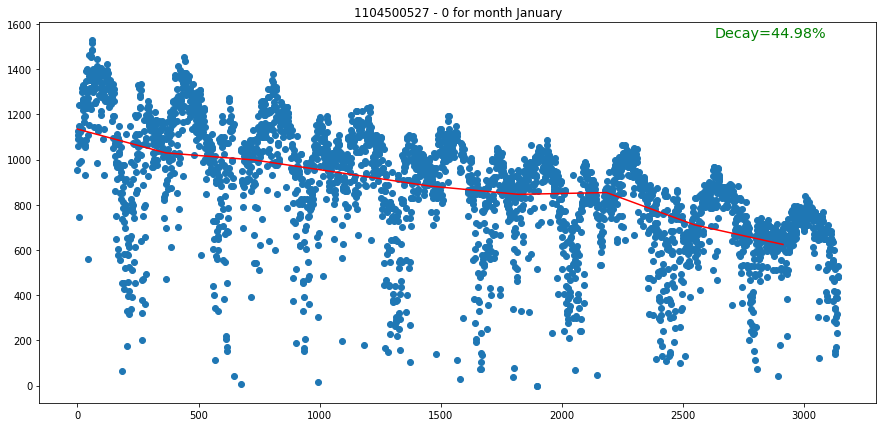

[1271.607142857143, 1139.7857142857142, 1131.892857142857, 1045.2758620689656, 1014.1071428571429, 883.2142857142857, 896.0714285714286, 831.6551724137931, 722.1785714285714]


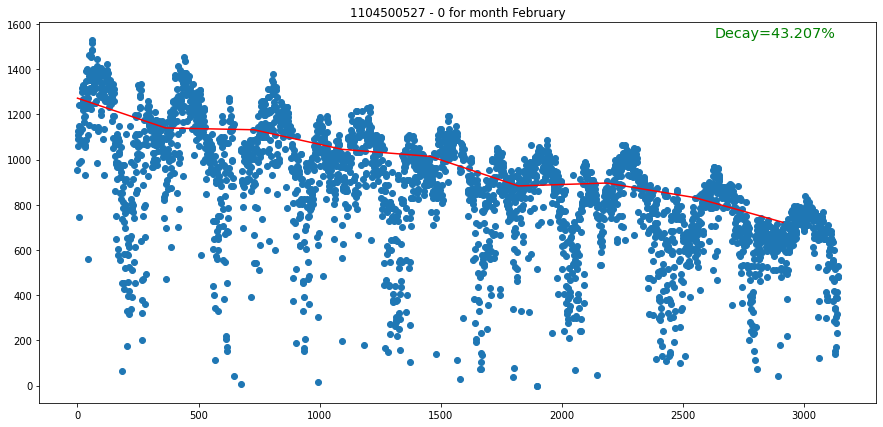

[1333.7096774193549, 1300.4516129032259, 1148.5483870967741, 1020.4615384615385, 1073.0645161290322, 894.483870967742, 976.0322580645161, 824.1612903225806, 754.4193548387096]


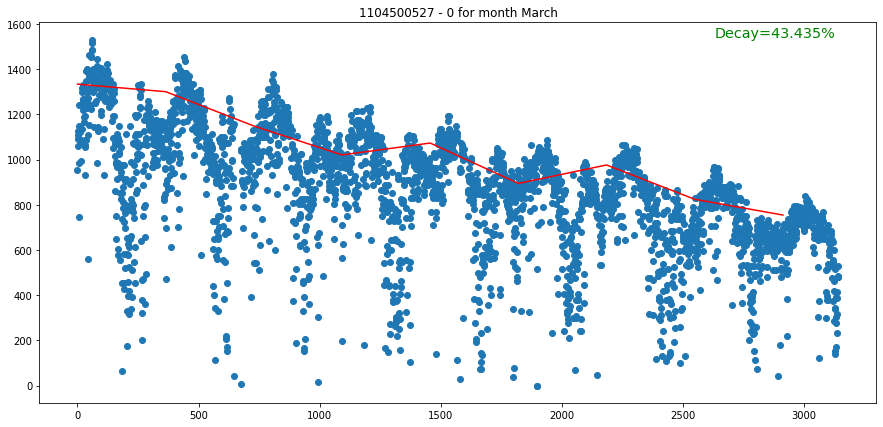

[1300.2, 1256.5666666666666, 1143.3, 1075.6333333333334, 987.65, 978.0666666666667, 970.516129032258, 860.5333333333333, 752.8333333333334]


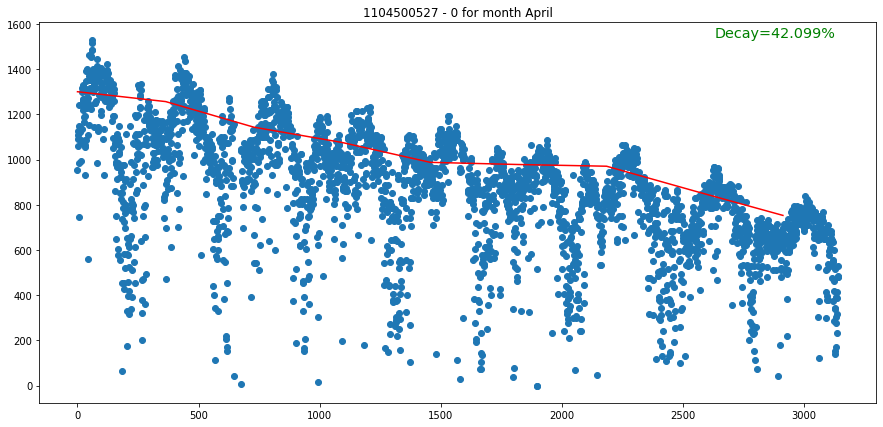

[1286.774193548387, 1176.6451612903227, 1139.258064516129, 1009.0, 966.1111111111111, 901.516129032258, 875.1666666666666, 828.5806451612904, 663.2258064516129]


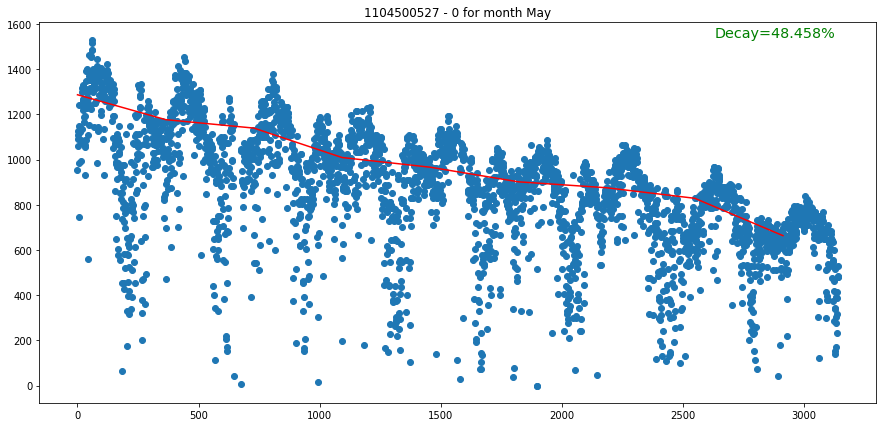

[954.6666666666666, 1074.8, 869.6666666666666, 859.9, 828.7, 761.4333333333333, 747.4, 724.2068965517242, 616.2333333333333]


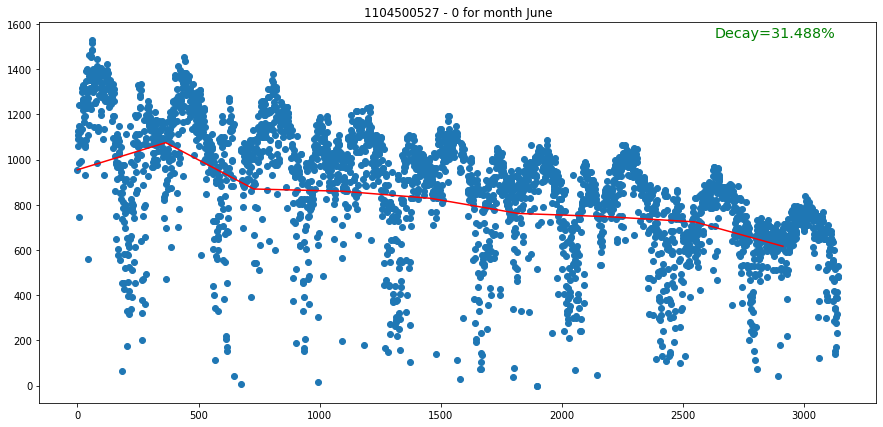

[663.3548387096774, 820.1290322580645, 692.8620689655172, 648.483870967742, 524.483870967742, 502.4193548387097, 627.1612903225806, 646.8666666666667, 489.7096774193548]


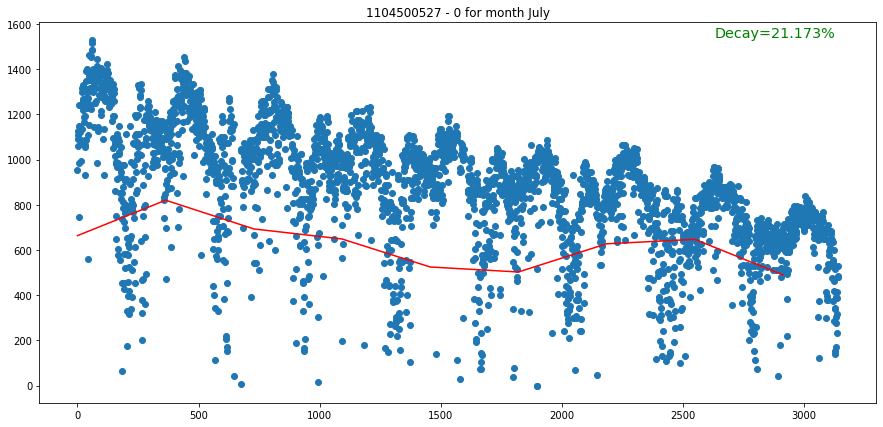

[776.1612903225806, 875.0, 809.1612903225806, 527.6129032258065, 693.2903225806451, 542.1935483870968, 523.5806451612904, 415.4193548387097, 415.25]


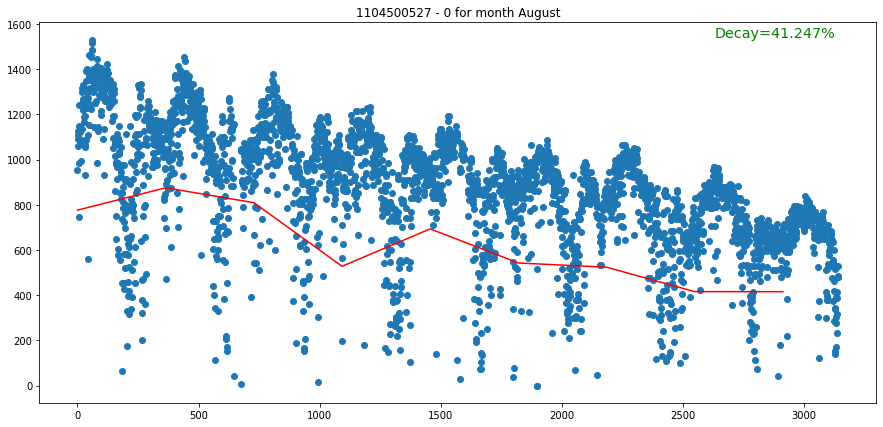

[1177.9354838709678, 1083.0967741935483, 1047.9032258064517, 1064.6129032258063, 1010.8709677419355, 1012.1290322580645, 1044.0645161290322, 983.0, 952.2903225806451]


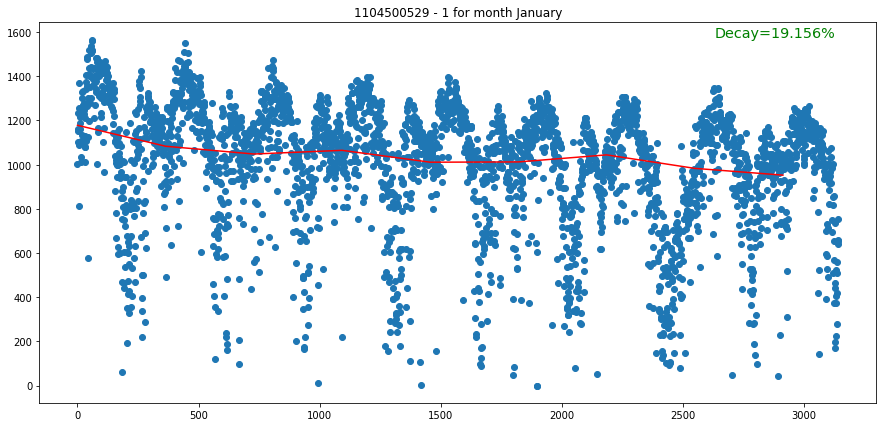

[1314.2857142857142, 1206.392857142857, 1201.3214285714287, 1198.7241379310344, 1198.142857142857, 1070.857142857143, 1096.357142857143, 1144.1379310344828, 1119.642857142857]


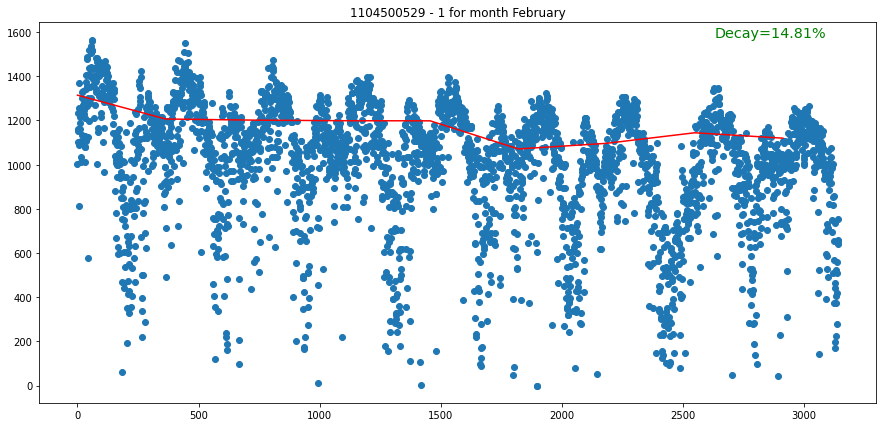

[1375.6129032258063, 1365.0, 1222.967741935484, 1195.5806451612902, 1256.225806451613, 1077.8064516129032, 1186.483870967742, 1127.5483870967741, 1158.2903225806451]


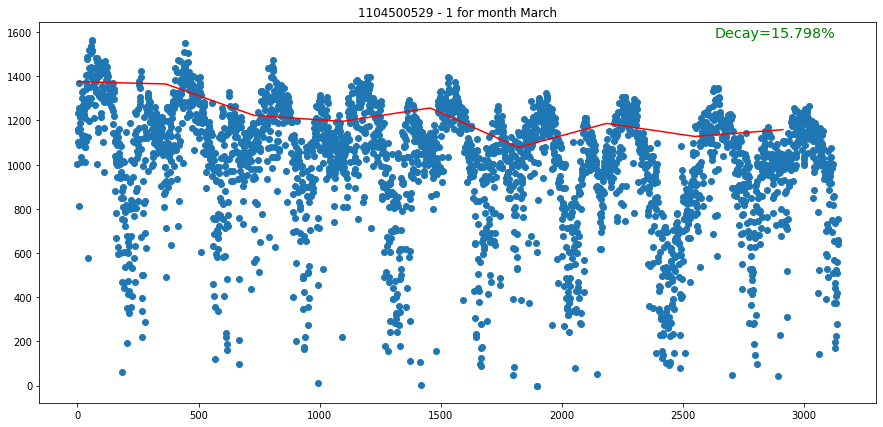

[1352.4666666666667, 1324.0333333333333, 1228.3, 1232.4333333333334, 1264.4333333333334, 1187.9666666666667, 1196.3225806451612, 1183.8, 1129.7]


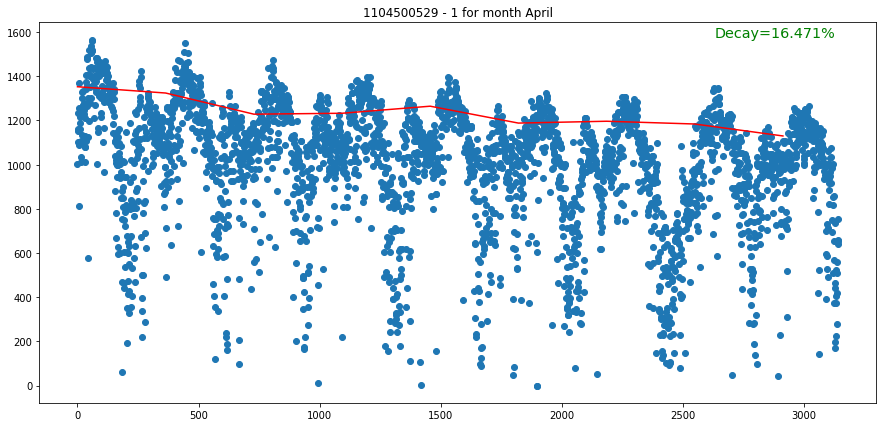

[1326.0, 1237.9354838709678, 1229.3548387096773, 1148.774193548387, 1145.4516129032259, 1097.032258064516, 1063.8, 1127.5806451612902, 1008.8387096774194]


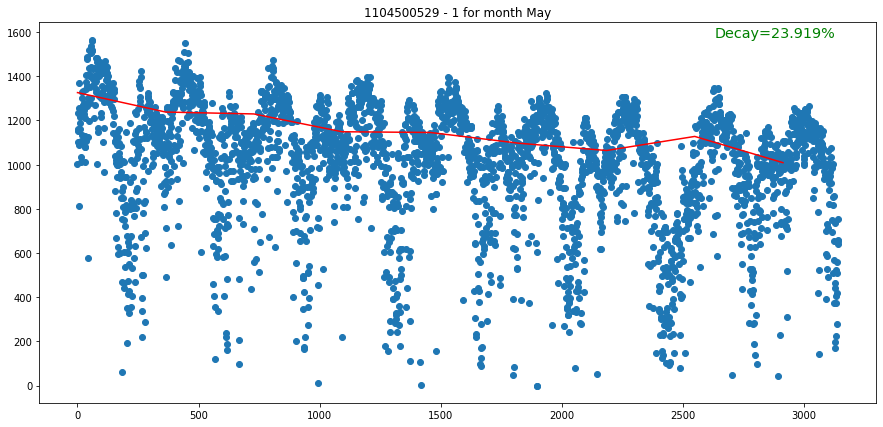

[982.7666666666667, 1132.5333333333333, 942.4, 966.5333333333333, 982.4666666666667, 909.2, 900.2, 970.2068965517242, 895.6666666666666]


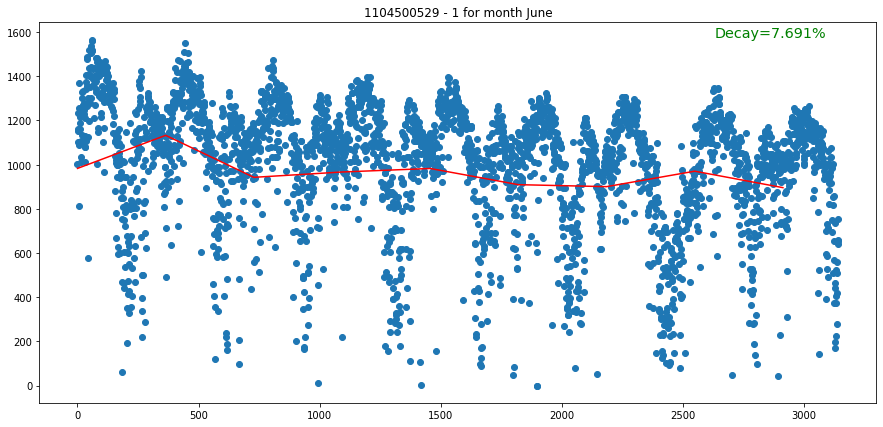

[686.2258064516129, 853.6451612903226, 752.8965517241379, 713.9677419354839, 617.8709677419355, 573.516129032258, 747.516129032258, 869.7666666666667, 721.8709677419355]


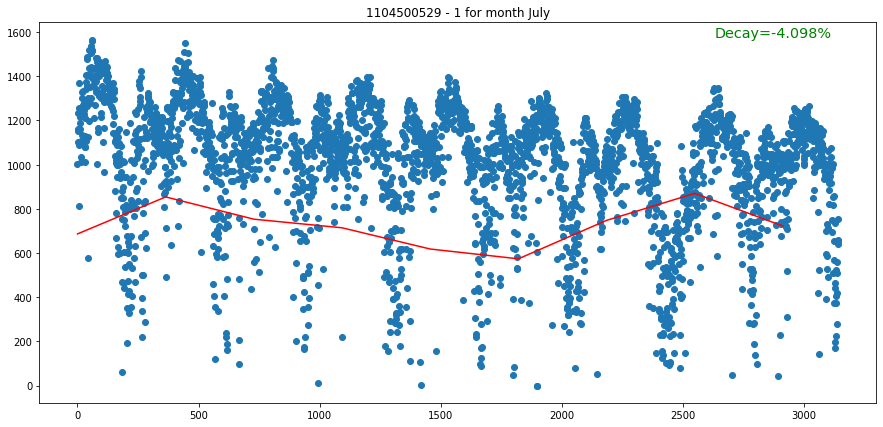

[796.7741935483871, 911.2903225806451, 839.8064516129032, 586.1612903225806, 816.0967741935484, 629.3548387096774, 446.61290322580646, 577.5483870967741, 559.5]


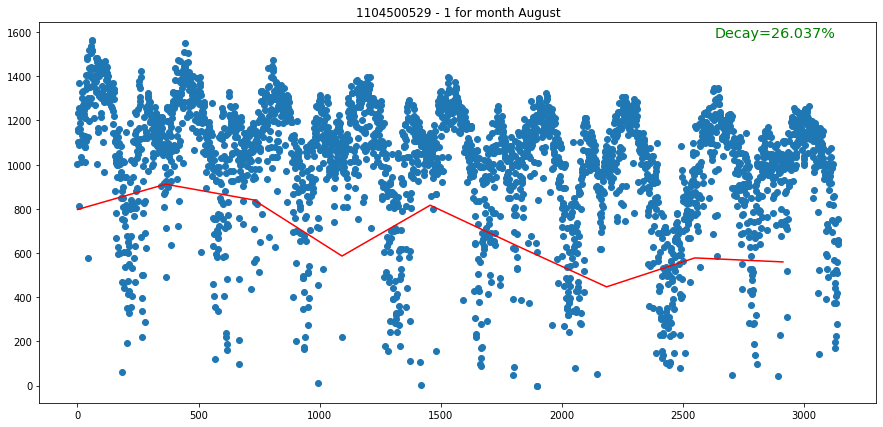

[1168.967741935484, 1064.6451612903227, 1061.1935483870968, 1050.3225806451612, 1001.5806451612904, 852.8064516129032, 1013.258064516129, 934.0, 905.1290322580645]


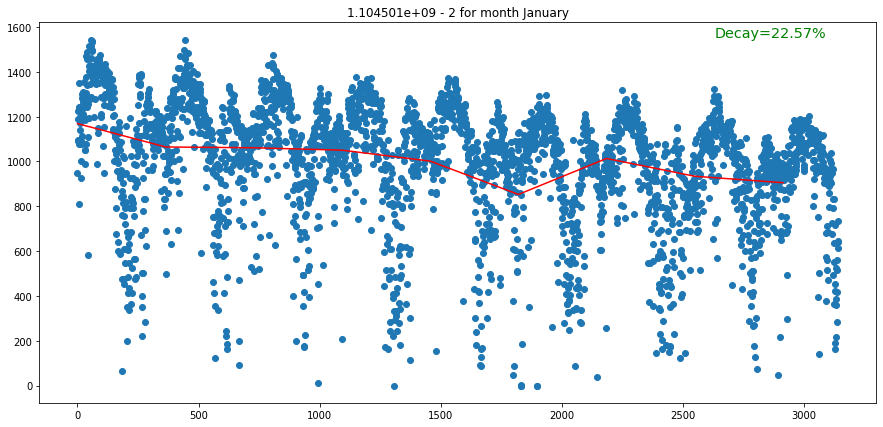

[1307.3214285714287, 1182.5714285714287, 1211.25, 1171.6896551724137, 1166.4642857142858, 1028.1785714285713, 1070.6785714285713, 1092.1379310344828, 1060.4285714285713]


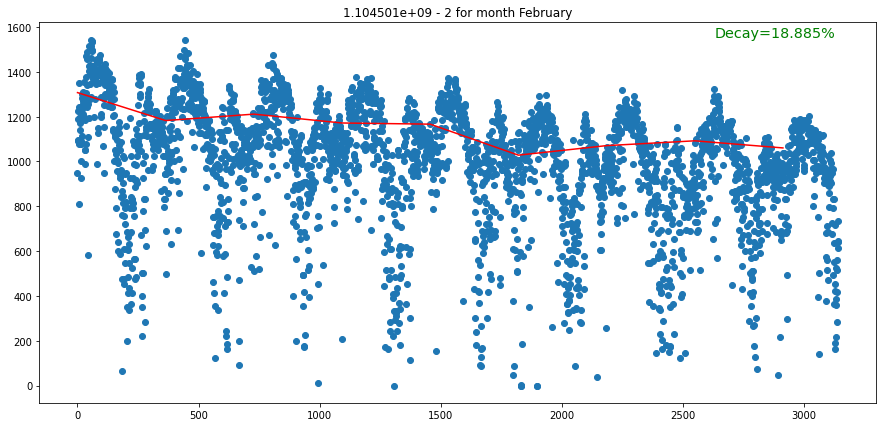

[1369.774193548387, 1345.3225806451612, 1220.774193548387, 1194.8064516129032, 1240.0967741935483, 1081.3870967741937, 1178.3225806451612, 1084.6451612903227, 1110.967741935484]


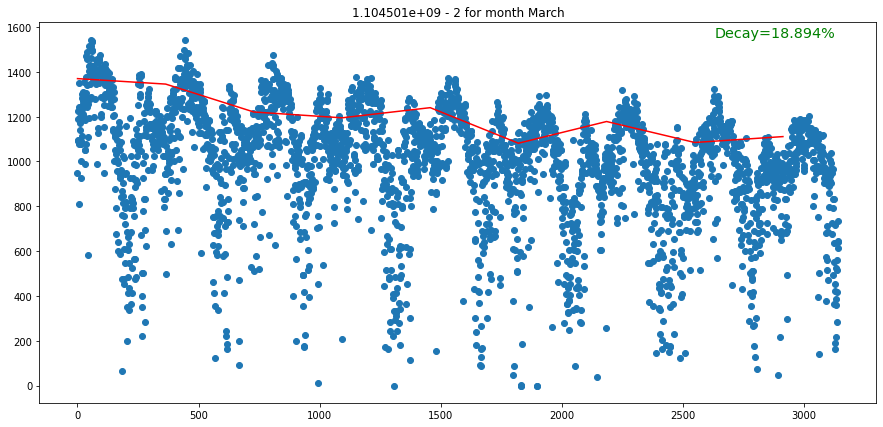

[1333.6333333333334, 1309.3, 1249.0333333333333, 1228.8666666666666, 1260.9, 1159.7666666666667, 1176.1290322580646, 1140.4333333333334, 1084.8]


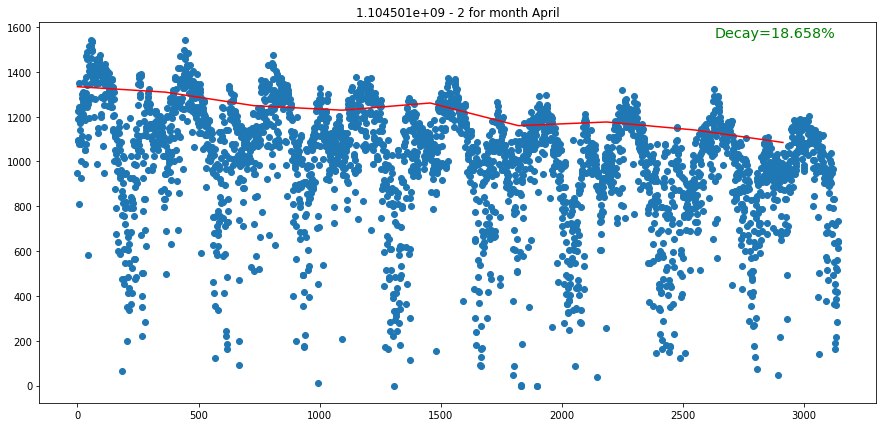

[1295.741935483871, 1236.7096774193549, 1240.483870967742, 1155.3870967741937, 1141.9032258064517, 1061.516129032258, 1063.3333333333333, 1100.7096774193549, 973.4193548387096]


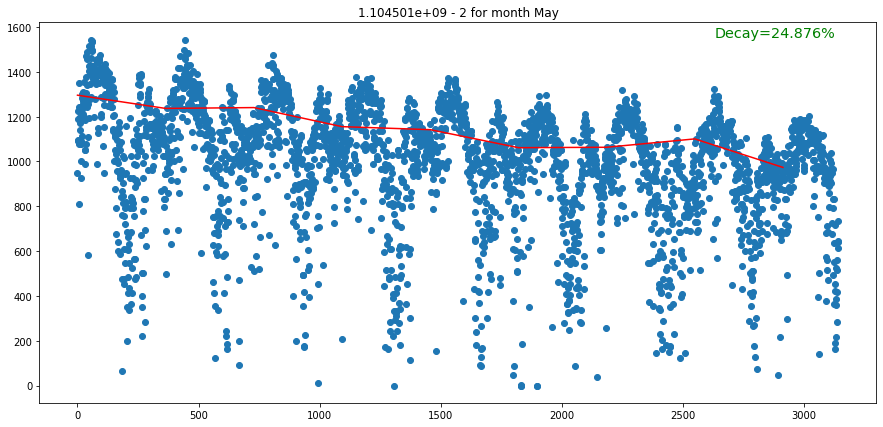

[991.8, 1138.9666666666667, 943.9333333333333, 957.8666666666667, 961.3666666666667, 893.4666666666667, 895.3333333333334, 936.9655172413793, 865.7666666666667]


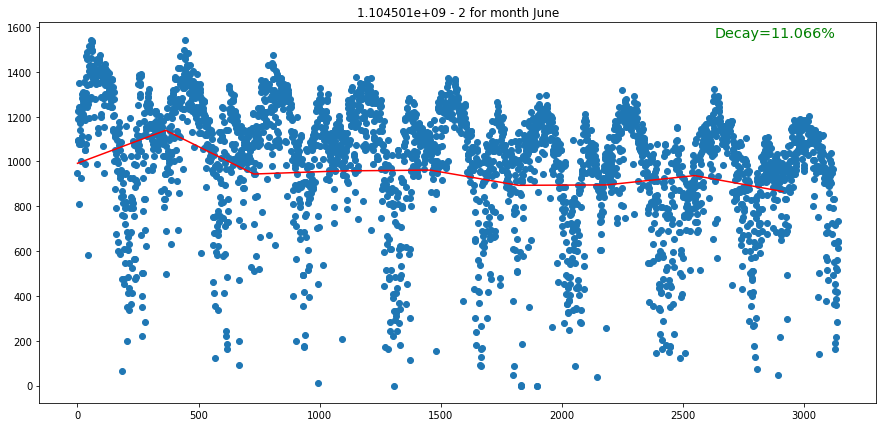

[690.6129032258065, 847.4516129032259, 758.9310344827586, 658.9032258064516, 602.9032258064516, 576.3870967741935, 744.6451612903226, 833.3333333333334, 699.741935483871]


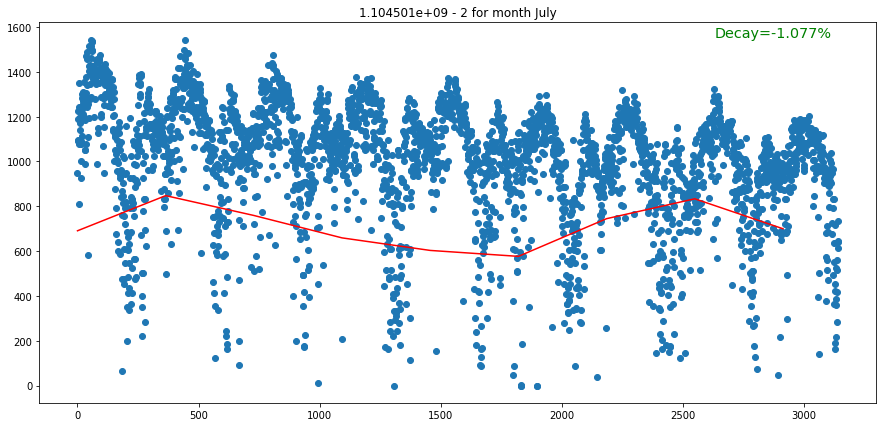

[757.3870967741935, 908.0, 875.1612903225806, 591.5806451612904, 817.0, 627.258064516129, 634.9354838709677, 553.6129032258065, 551.25]


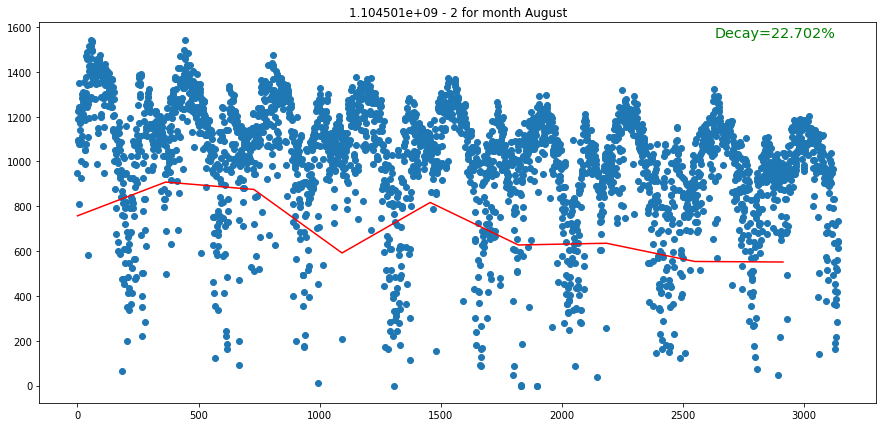

[1131.516129032258, 1008.9032258064516, 1011.6129032258065, 1051.5483870967741, nan, 987.741935483871, 1063.6774193548388, 1020.3939393939394, 997.9354838709677]


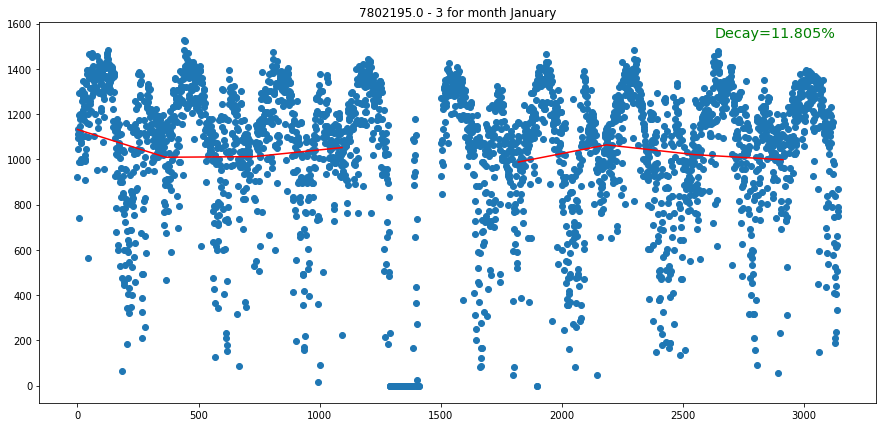

[1244.25, 1136.0357142857142, 1161.4285714285713, 1164.2758620689656, 1171.35, 1072.25, 1134.2142857142858, 1186.896551724138, 1179.4285714285713]


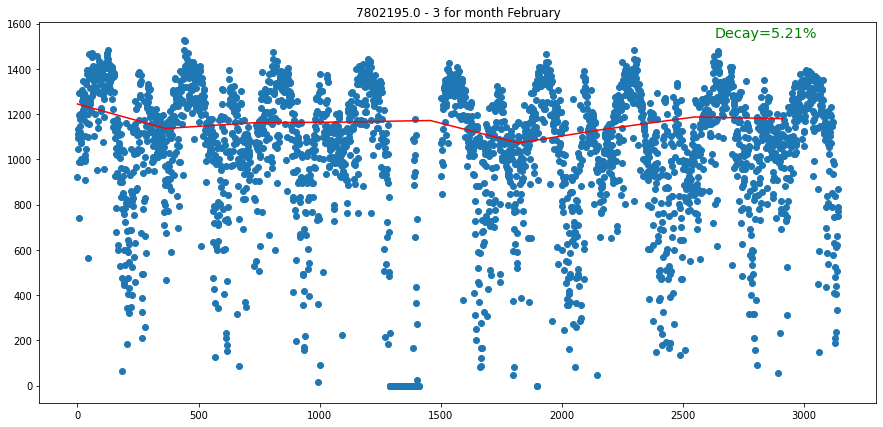

[1322.8387096774193, 1341.5483870967741, 1215.3548387096773, 1250.0283870967744, 1311.9032258064517, 1190.6129032258063, 1290.6451612903227, 1210.774193548387, 1263.483870967742]


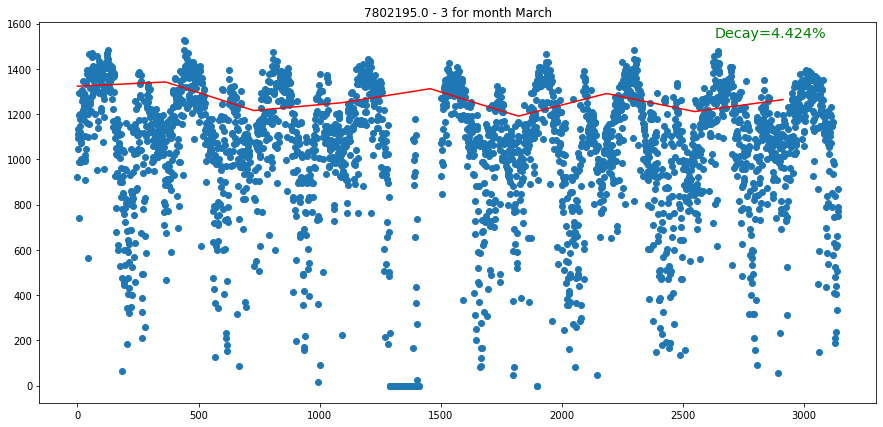

[1327.2333333333333, 1333.2333333333333, 1272.5, 1320.4333333333334, 1318.8666666666666, 1321.9, 1329.4516129032259, 1291.6666666666667, 1269.9666666666667]


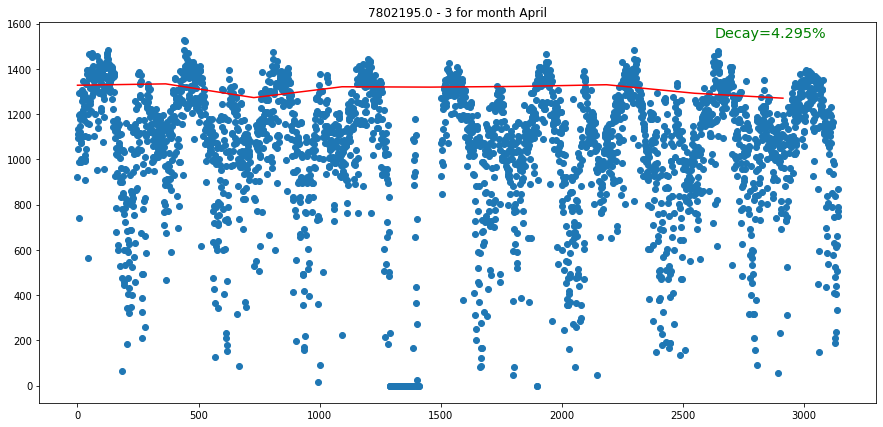

[1358.8387096774193, 1292.3870967741937, 1283.1935483870968, 1243.8064516129032, 1198.2903225806451, 1197.1612903225807, 1195.7333333333333, 1295.5483870967741, 1166.6451612903227]


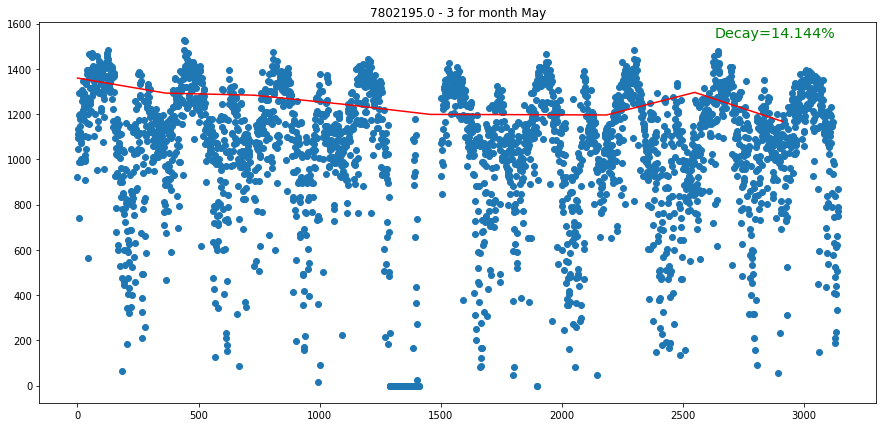

[999.3666666666667, 1152.9666666666667, 988.0, 1021.6666666666666, 1043.0, 1015.2333333333333, 975.8, 1112.0344827586207, 1033.2333333333333]


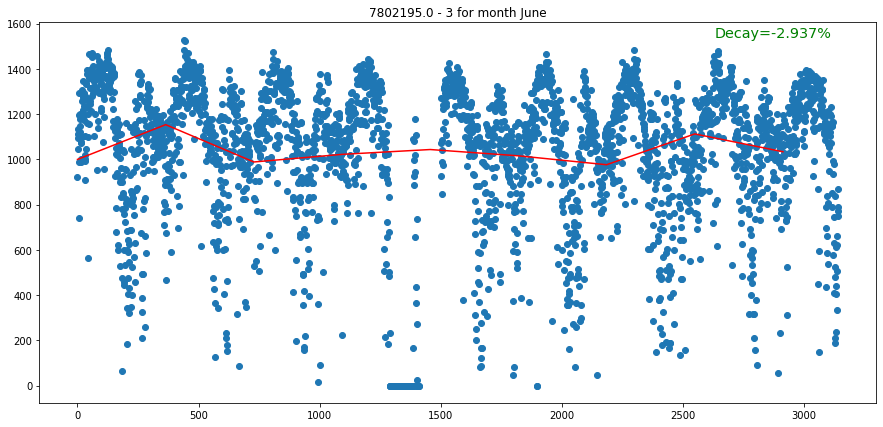

[689.516129032258, 879.7741935483871, 771.4827586206897, 276.6774193548387, 649.7096774193549, 638.6451612903226, 847.5483870967741, 996.9666666666667, 826.4516129032259]


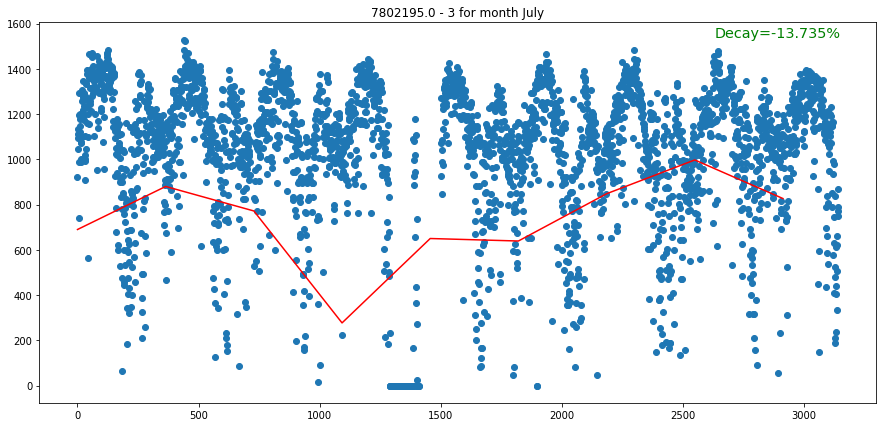

[803.516129032258, 950.9354838709677, 865.4, 0.0, 861.6451612903226, 694.258064516129, 749.0322580645161, 663.0322580645161, 662.125]


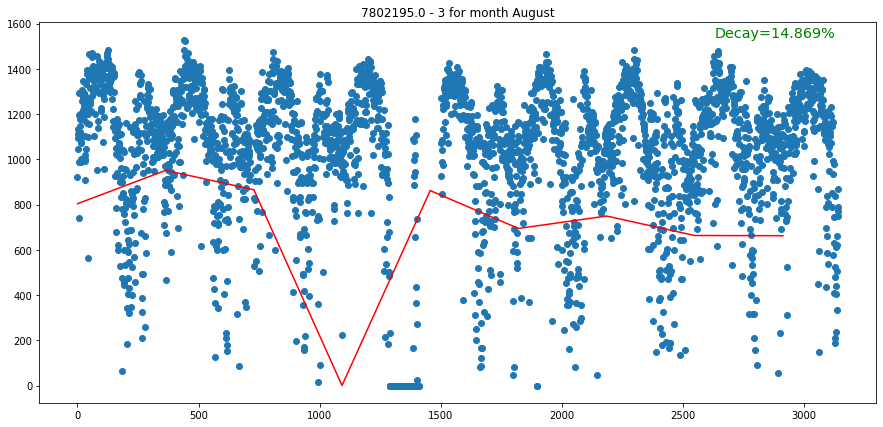

[15.984, 36.283548387096765, 56.5183870967742, 44.26, 34.58870967741935, 36.67483870967743, 38.76935483870969, 50.97060606060606, 56.759677419354844]


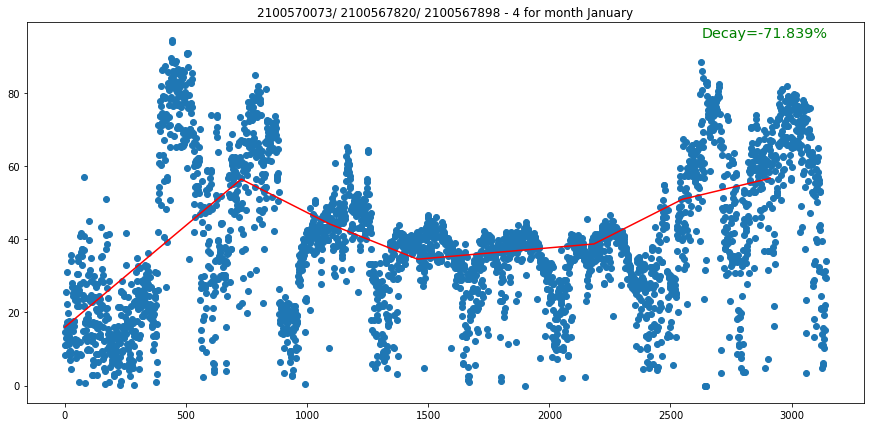

[21.858928571428574, 66.58142857142857, 67.33214285714284, 44.15965517241379, 40.574642857142855, 37.315714285714286, 39.309999999999995, 58.97034482758621, 67.99392857142857]


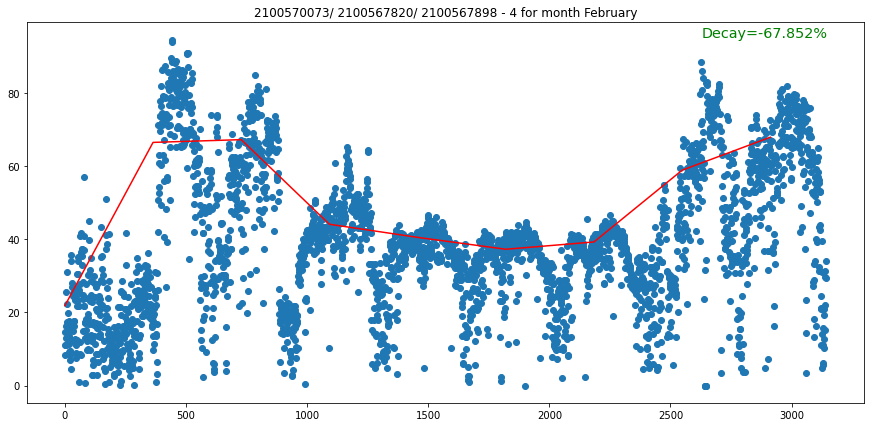

[25.214838709677423, 80.01161290322581, 62.31612903225807, 52.17903225806452, 38.37935483870968, 39.171612903225814, 40.71354838709678, 52.903225806451616, 71.45645161290321]


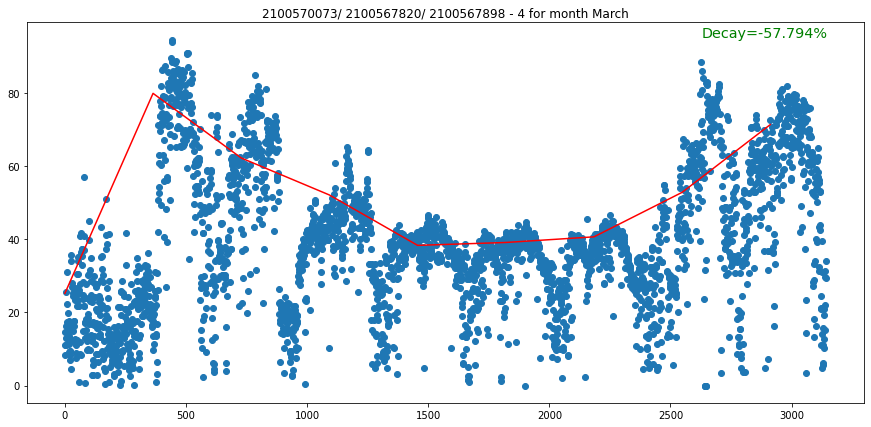

[19.46433333333334, 78.93866666666665, 63.26366666666668, 47.47400000000001, 39.97466666666667, 38.98233333333334, 39.738709677419365, 73.19833333333332, 69.71566666666668]


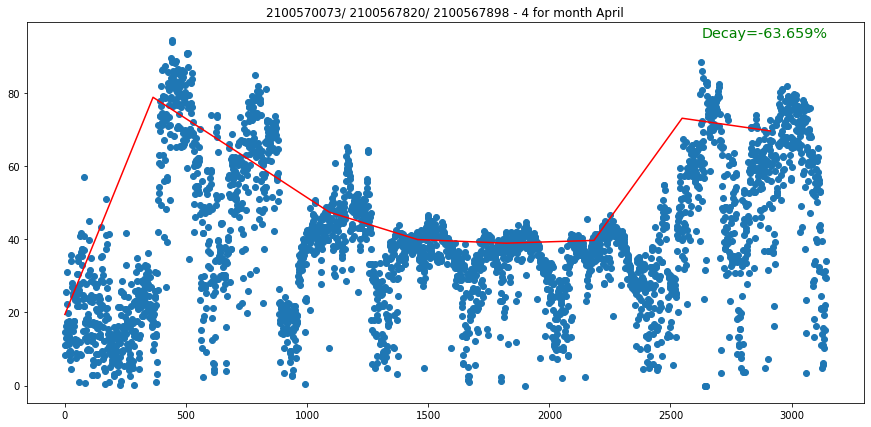

[18.949310344827584, 75.22258064516129, 64.65967741935485, 45.979677419354836, 35.320645161290315, 33.94841935483871, 33.077333333333335, 74.1125806451613, 61.653225806451616]


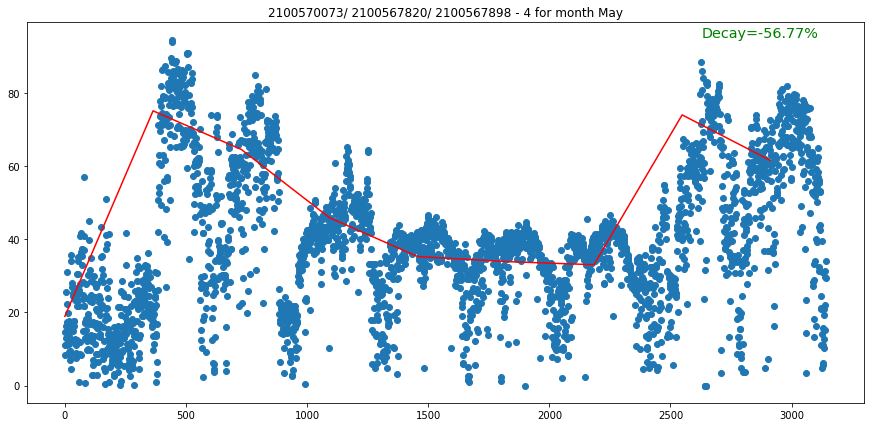

[20.750000000000004, 65.40333333333332, 20.97833333333333, 38.28, 30.314333333333334, 28.37793333333333, 27.420000000000005, 46.083103448275864, 50.20266666666667]


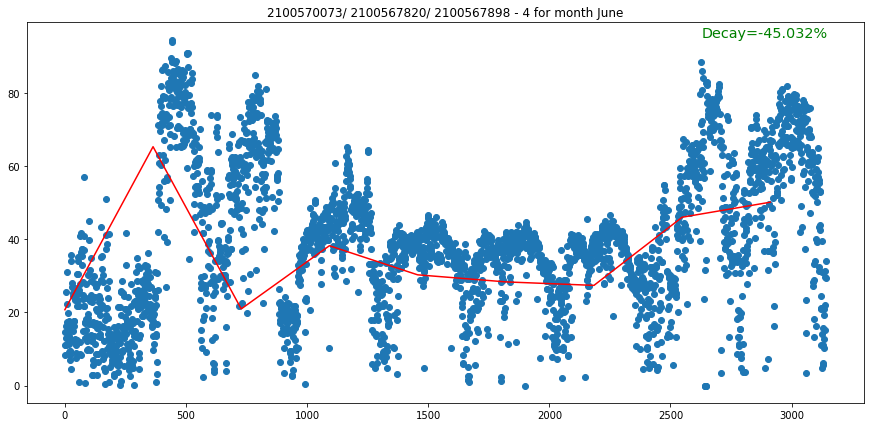

[11.665806451612905, 41.339677419354835, 15.297931034482756, 22.011290322580646, 18.590967741935483, 18.779032258064515, 24.52967741935484, 44.589000000000006, 35.43648387096774]


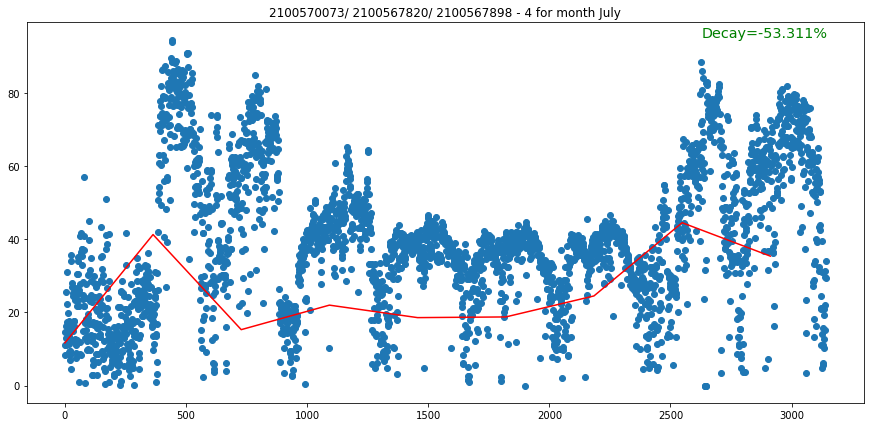

[12.48709677419355, 42.39032258064517, 21.609032258064516, 18.458709677419357, 25.555161290322584, 21.218709677419355, 21.833225806451615, 24.83193548387097, 24.15875]


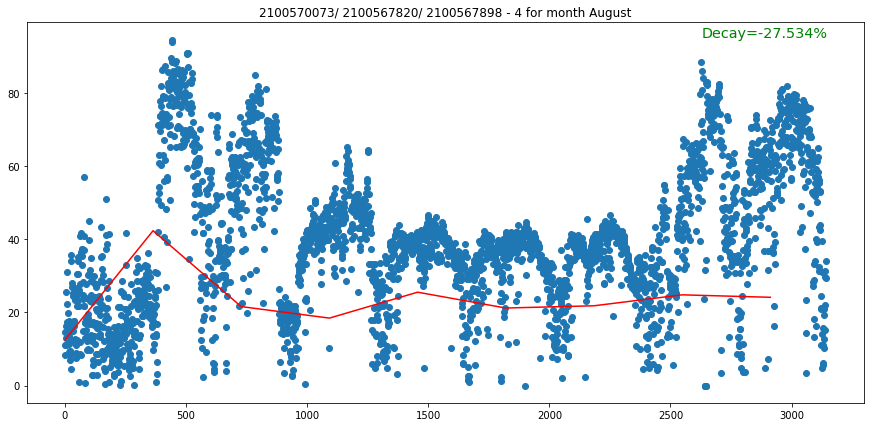

In [41]:
month_name = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
for module in modules:
    for i in range(12):
        temp = []
        temp2 = []
        try:
            for year in years:
                temp.append(dict_mean[year][module][i])
                temp2.extend(df_obj[year][module])
        except:
            continue
        print(temp)
        decay = ((temp[0]-temp[-1])/max(temp))*100
        fig = plt.figure(figsize=(15,7))
        plt.scatter(range(len(temp2)), temp2)
#         plt.scatter(range(len(years)), temp)
        plt.plot(range(0, len(temp2), 364), temp, c="r")
        plt.title(module + " - " + str(modules.index(module)) +" for month "+ month_name[i])
        plt.figtext(.75, .85, "Decay="+str(round(decay, 3))+"%", c='g',fontsize='x-large')
        plt.show()
        filename = str(module + " - " + str(modules.index(module)) +" for month "+ month_name[i]).replace("/", "")
        path = "result/decay/" + filename
        path = path.replace(".", "")
        fig.savefig(path, dpi=500)

In [45]:
dict_mean

{'2013': {'1104500527': [1134.7096774193549,
   1271.607142857143,
   1333.7096774193549,
   1300.2,
   1286.774193548387,
   954.6666666666666,
   663.3548387096774,
   776.1612903225806,
   975.7666666666667,
   1066.3225806451612,
   1089.0333333333333,
   1051.516129032258],
  '1104500529': [1177.9354838709678,
   1314.2857142857142,
   1375.6129032258063,
   1352.4666666666667,
   1326.0,
   982.7666666666667,
   686.2258064516129,
   796.7741935483871,
   999.9,
   1121.1935483870968,
   1142.0,
   1087.0967741935483],
  '1.104501e+09': [1168.967741935484,
   1307.3214285714287,
   1369.774193548387,
   1333.6333333333334,
   1295.741935483871,
   991.8,
   690.6129032258065,
   757.3870967741935,
   1018.7333333333333,
   1112.258064516129,
   1125.9666666666667,
   1062.516129032258],
  '7802195.0': [1131.516129032258,
   1244.25,
   1322.8387096774193,
   1327.2333333333333,
   1358.8387096774193,
   999.3666666666667,
   689.516129032258,
   803.516129032258,
   1011.73333333

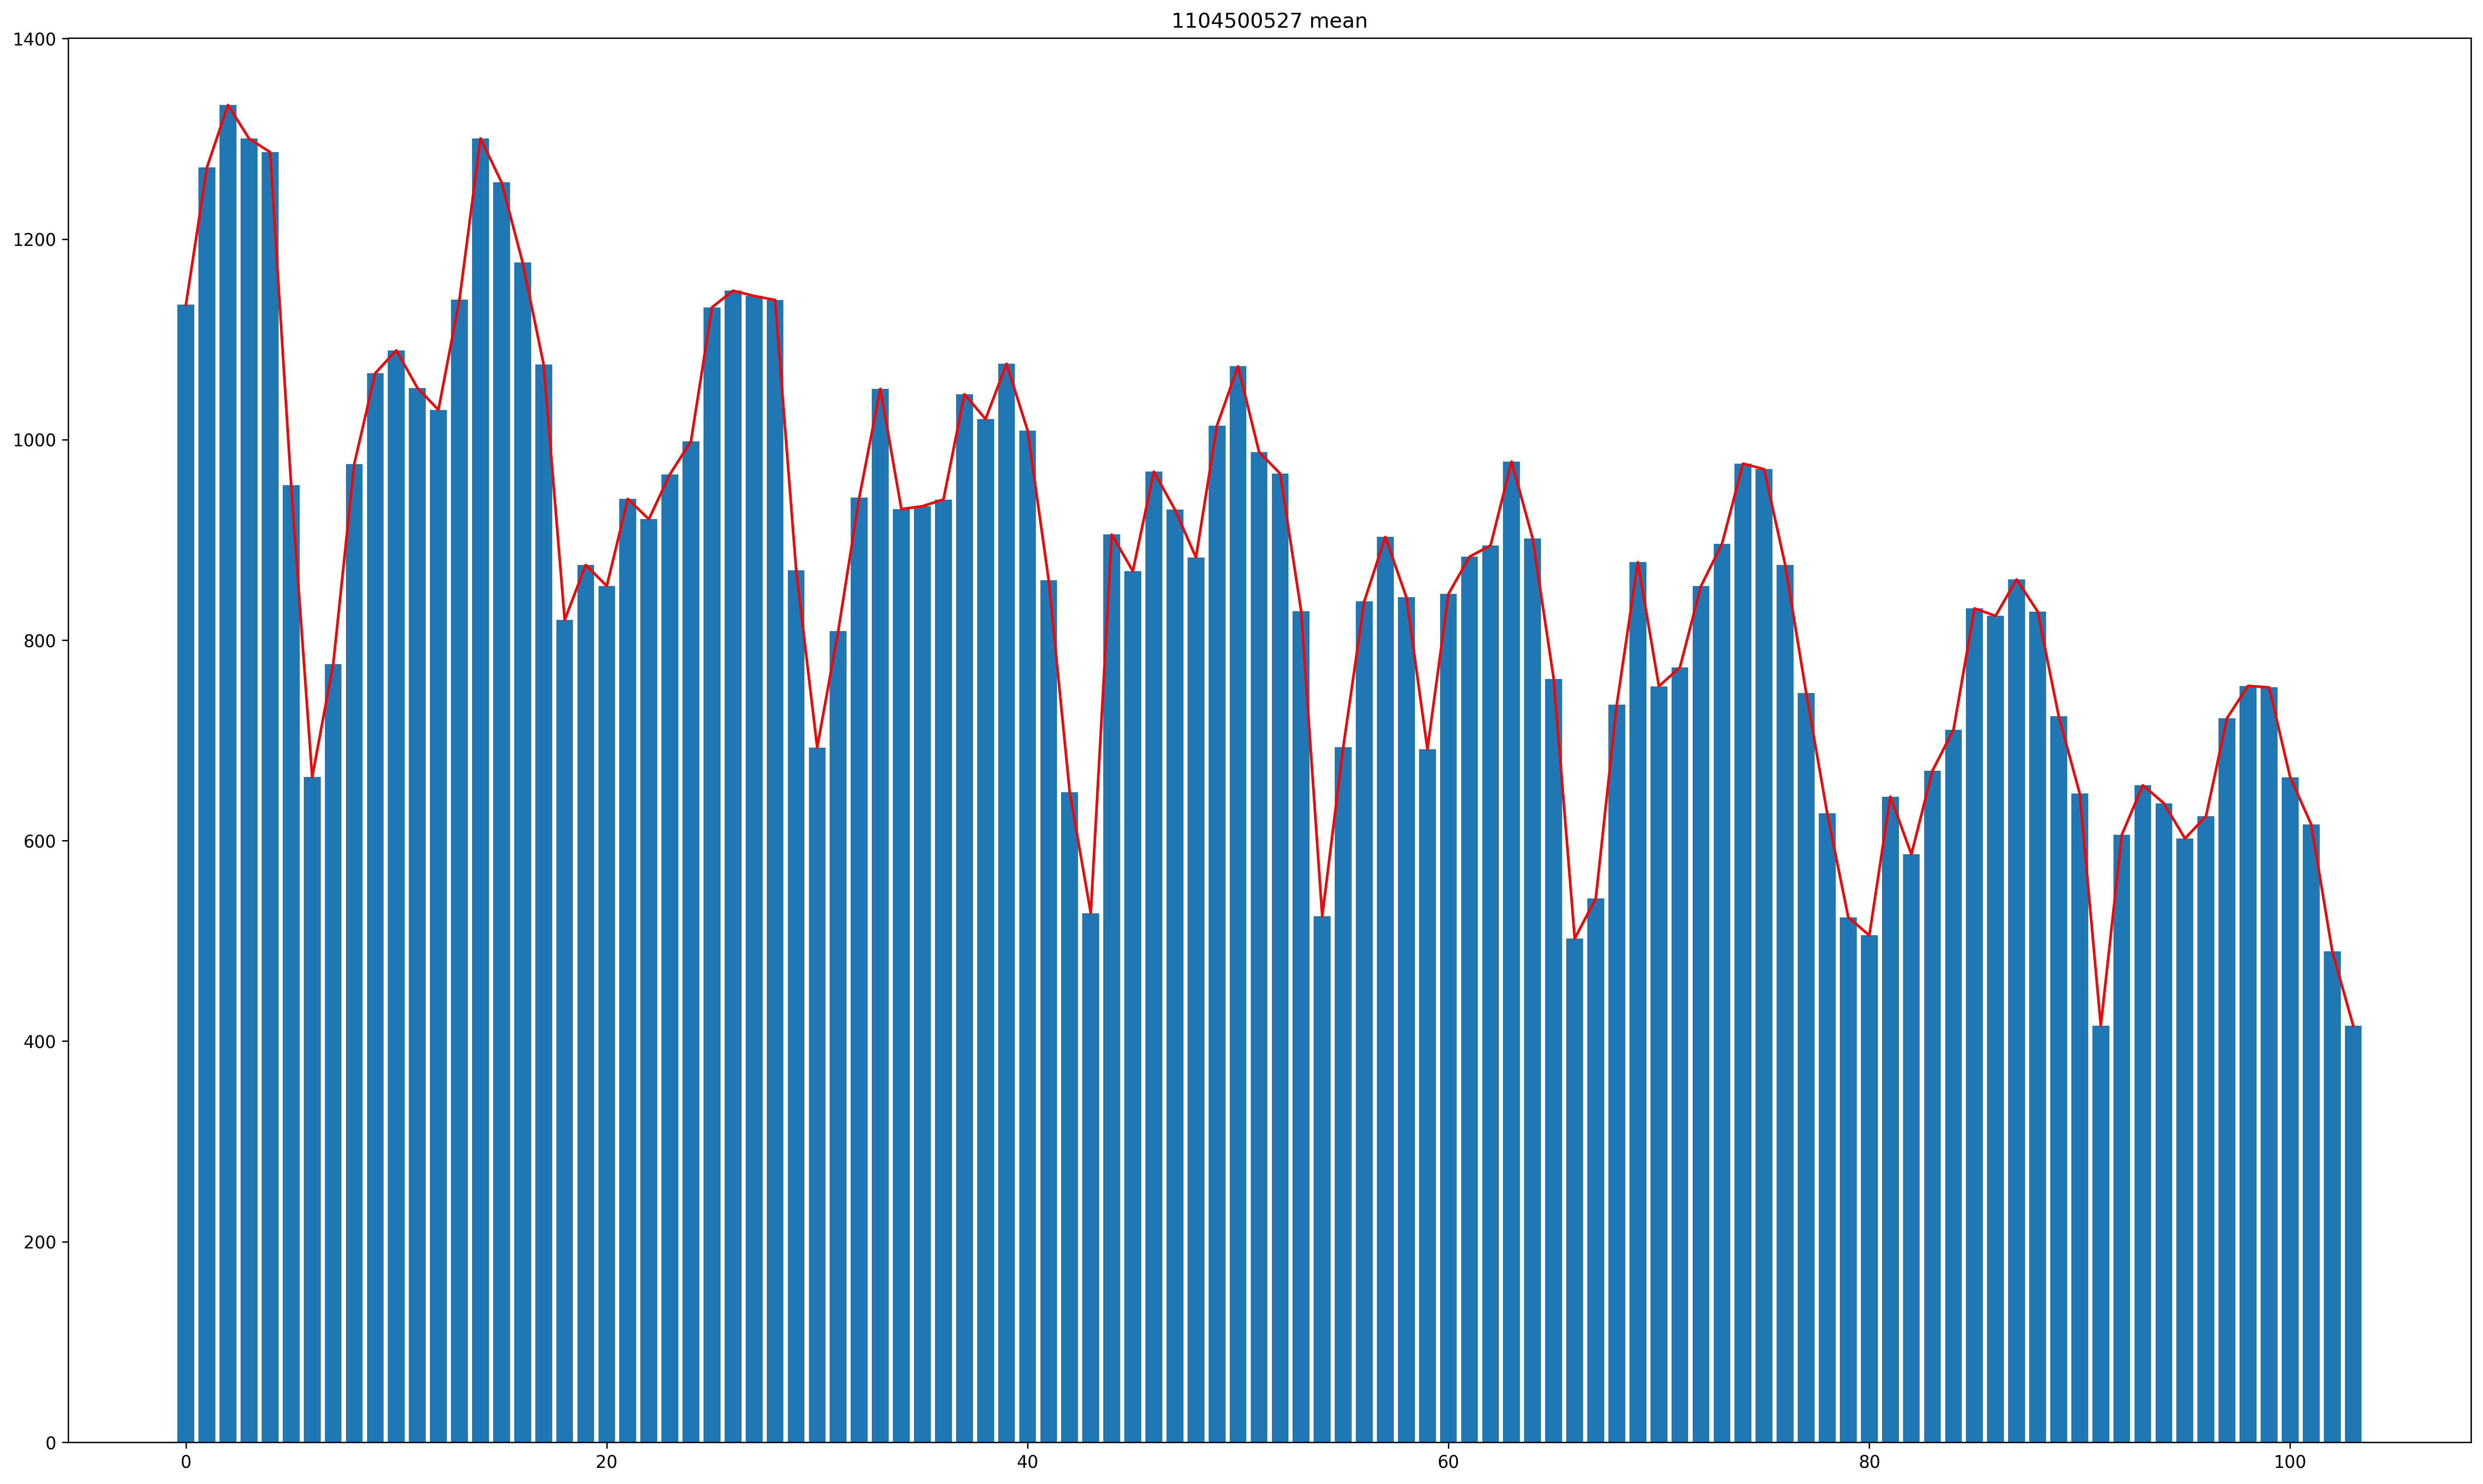

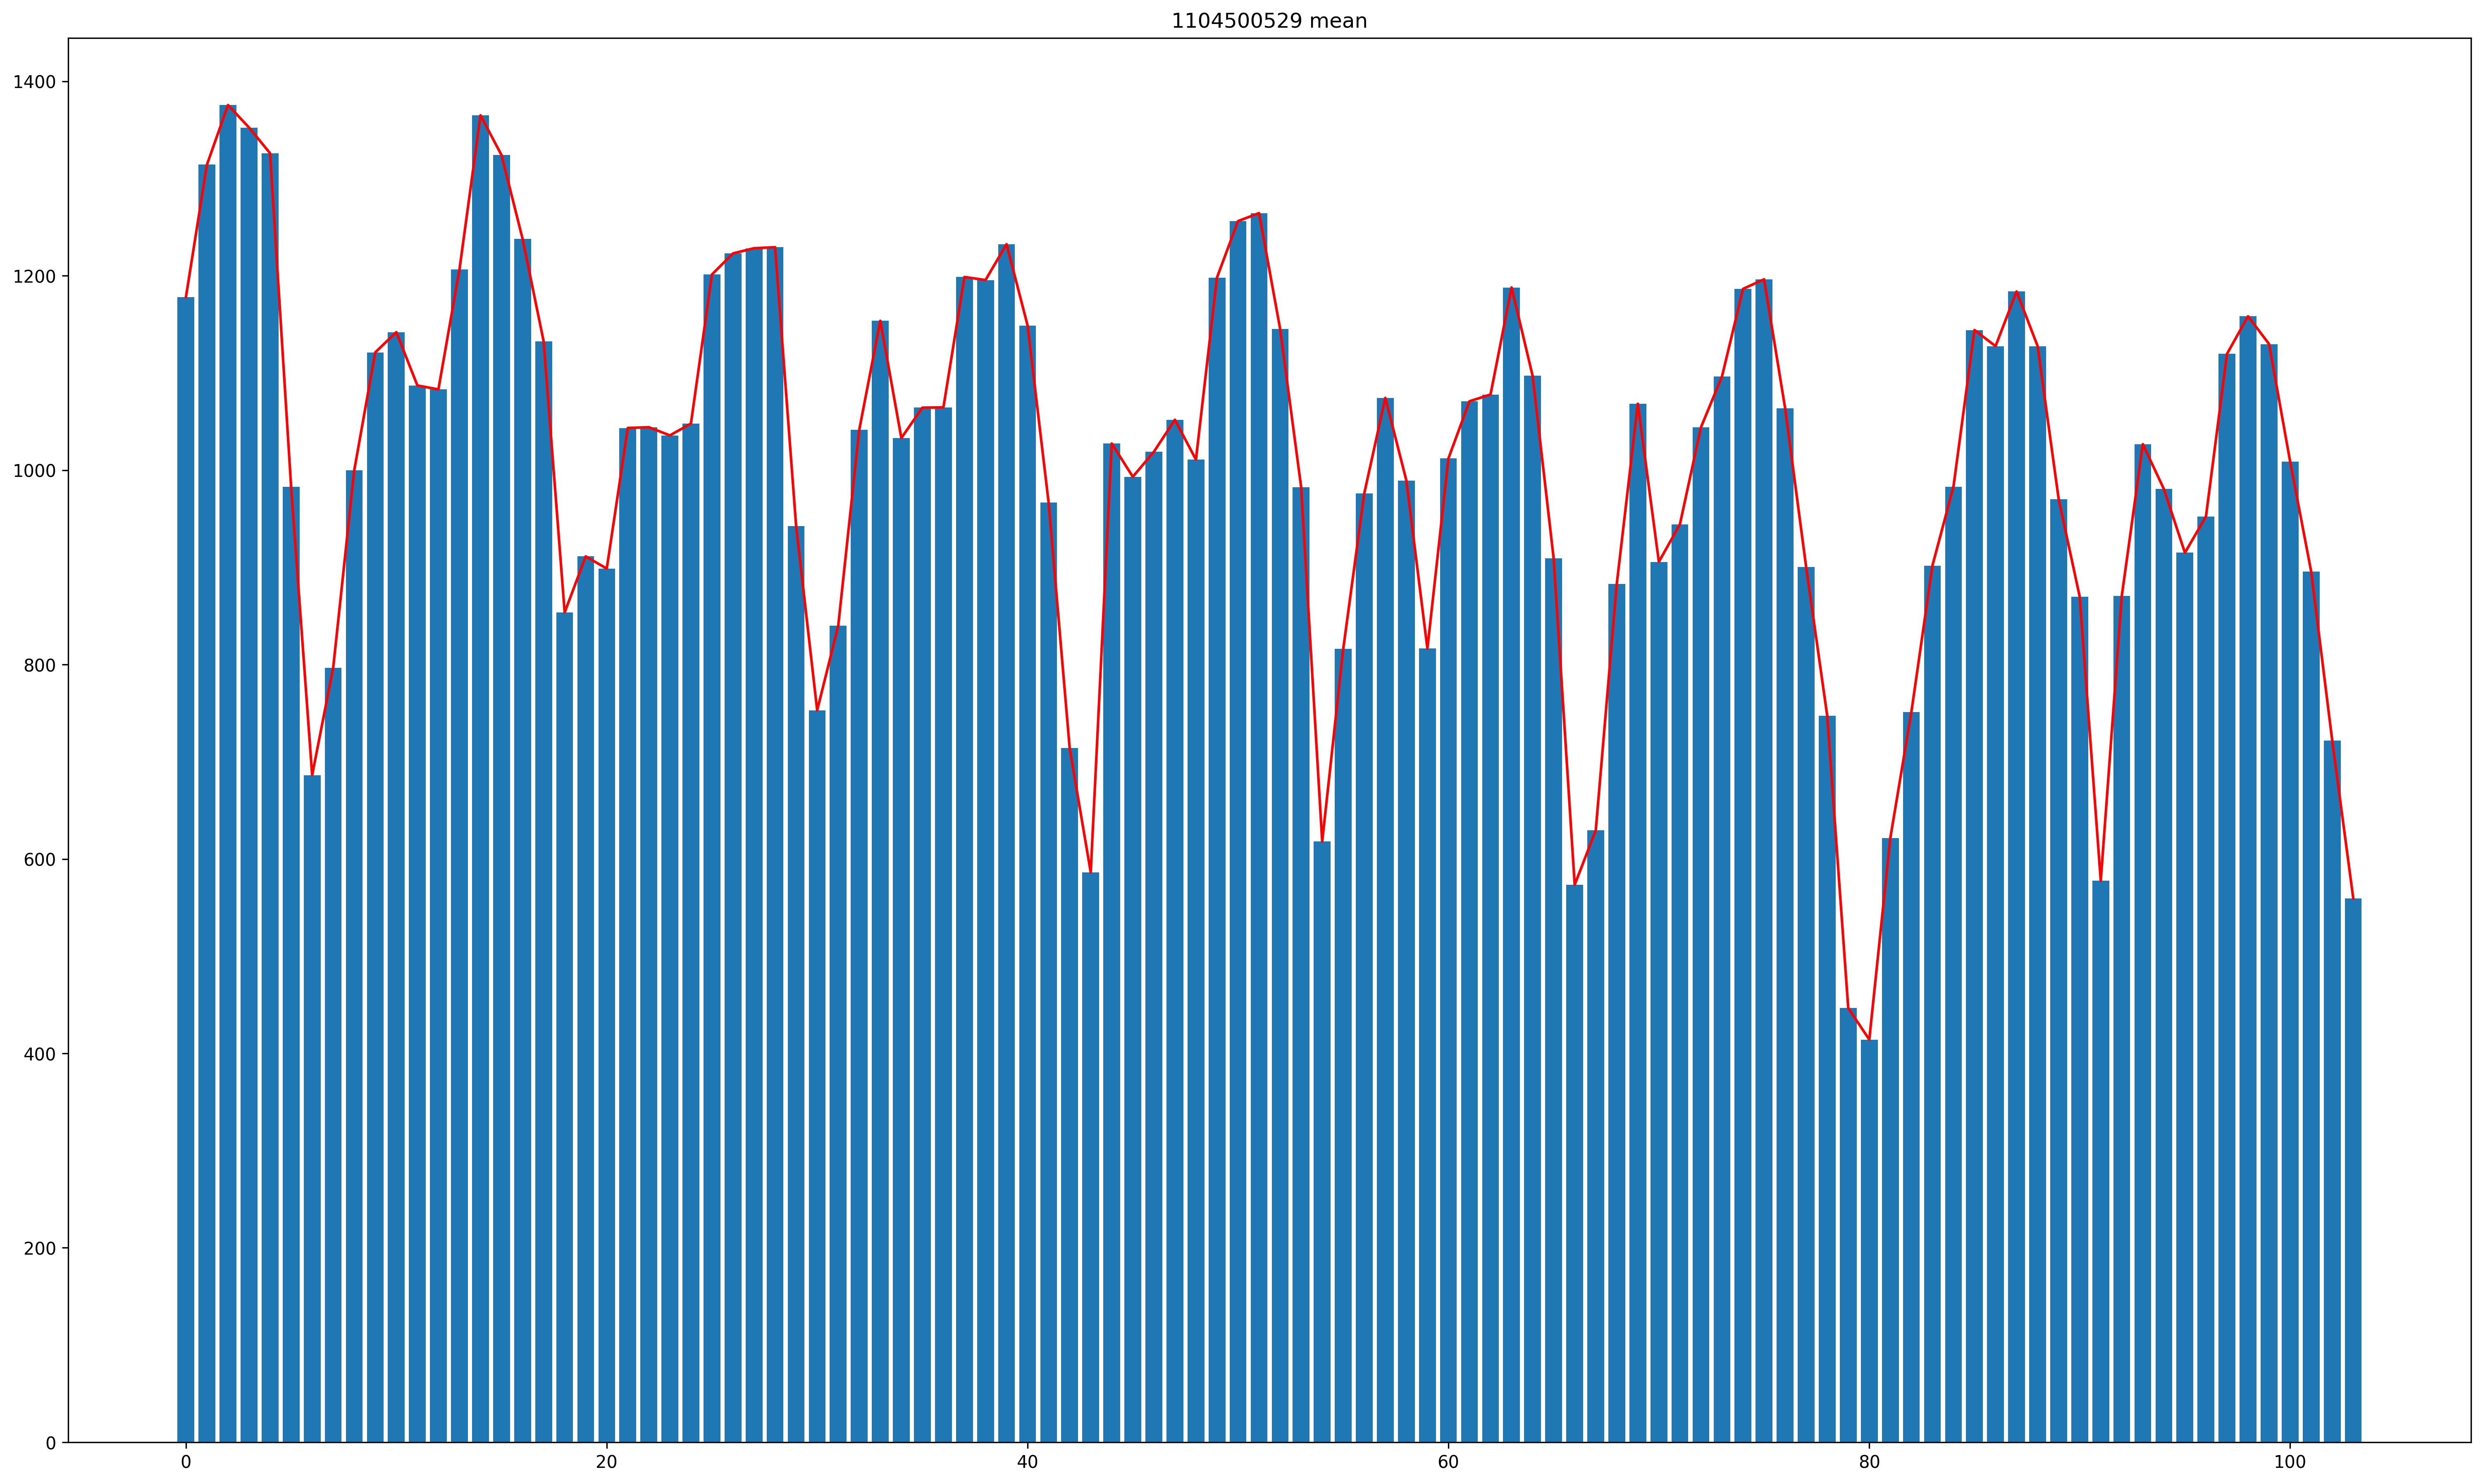

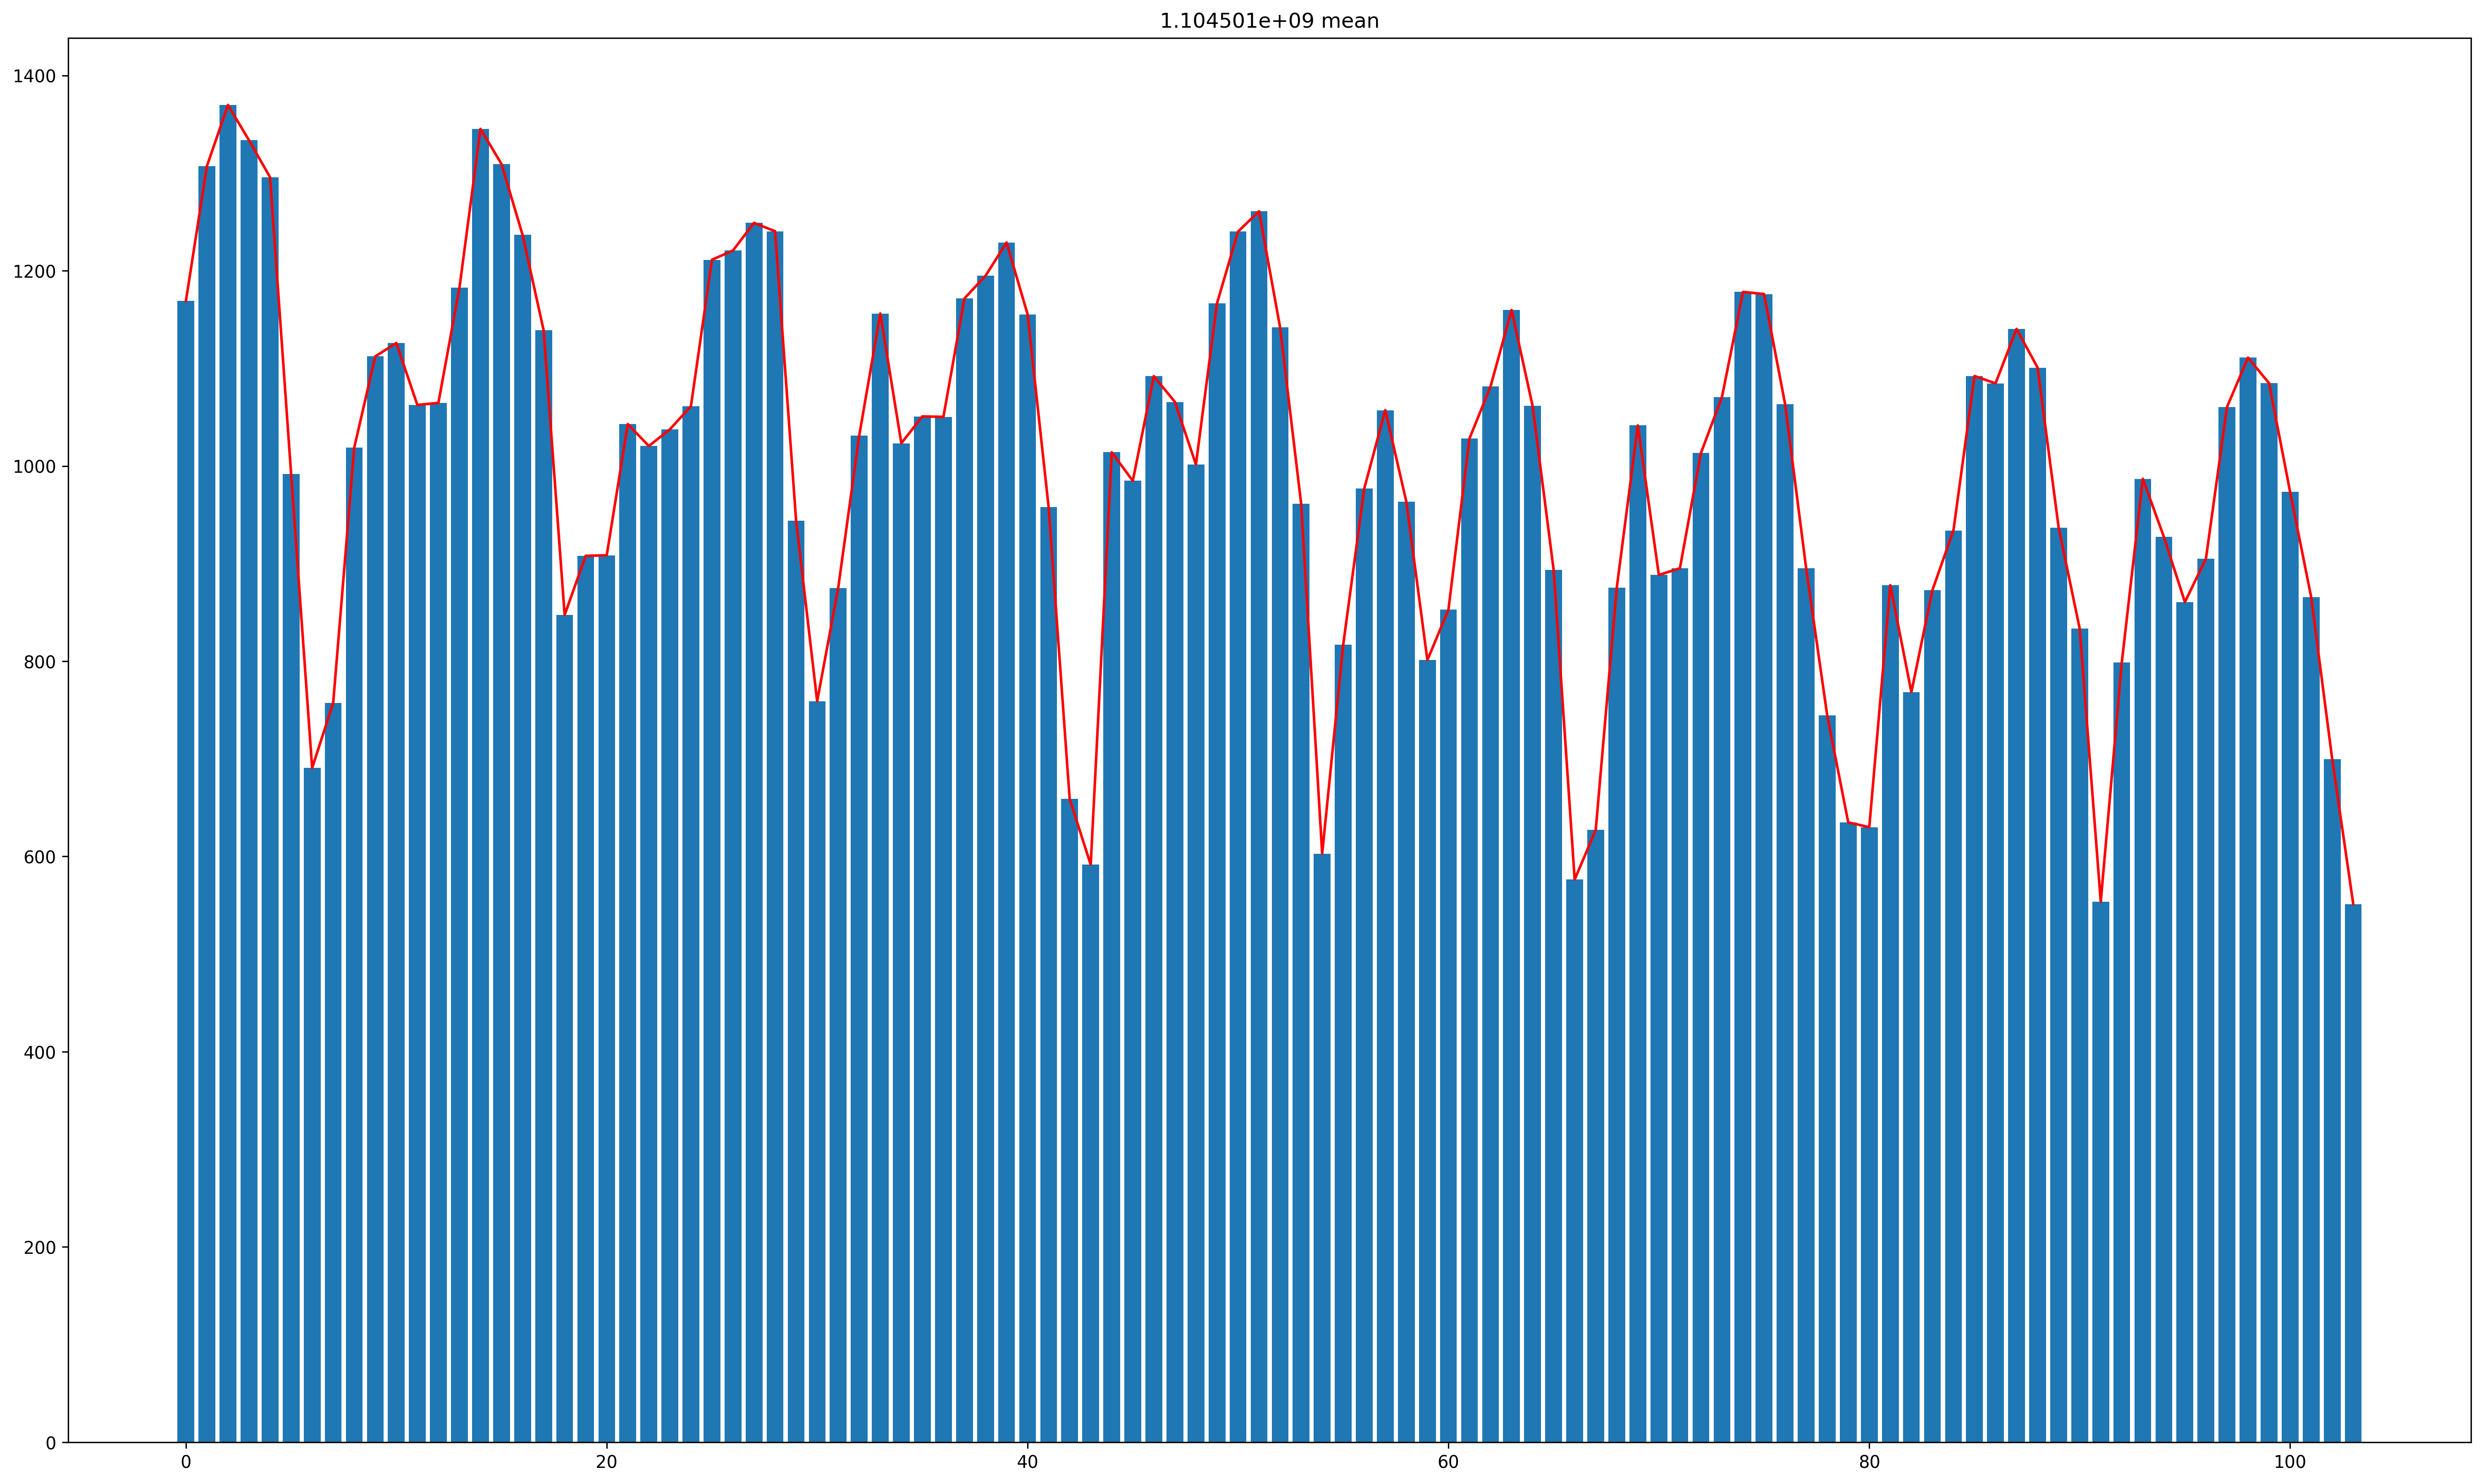

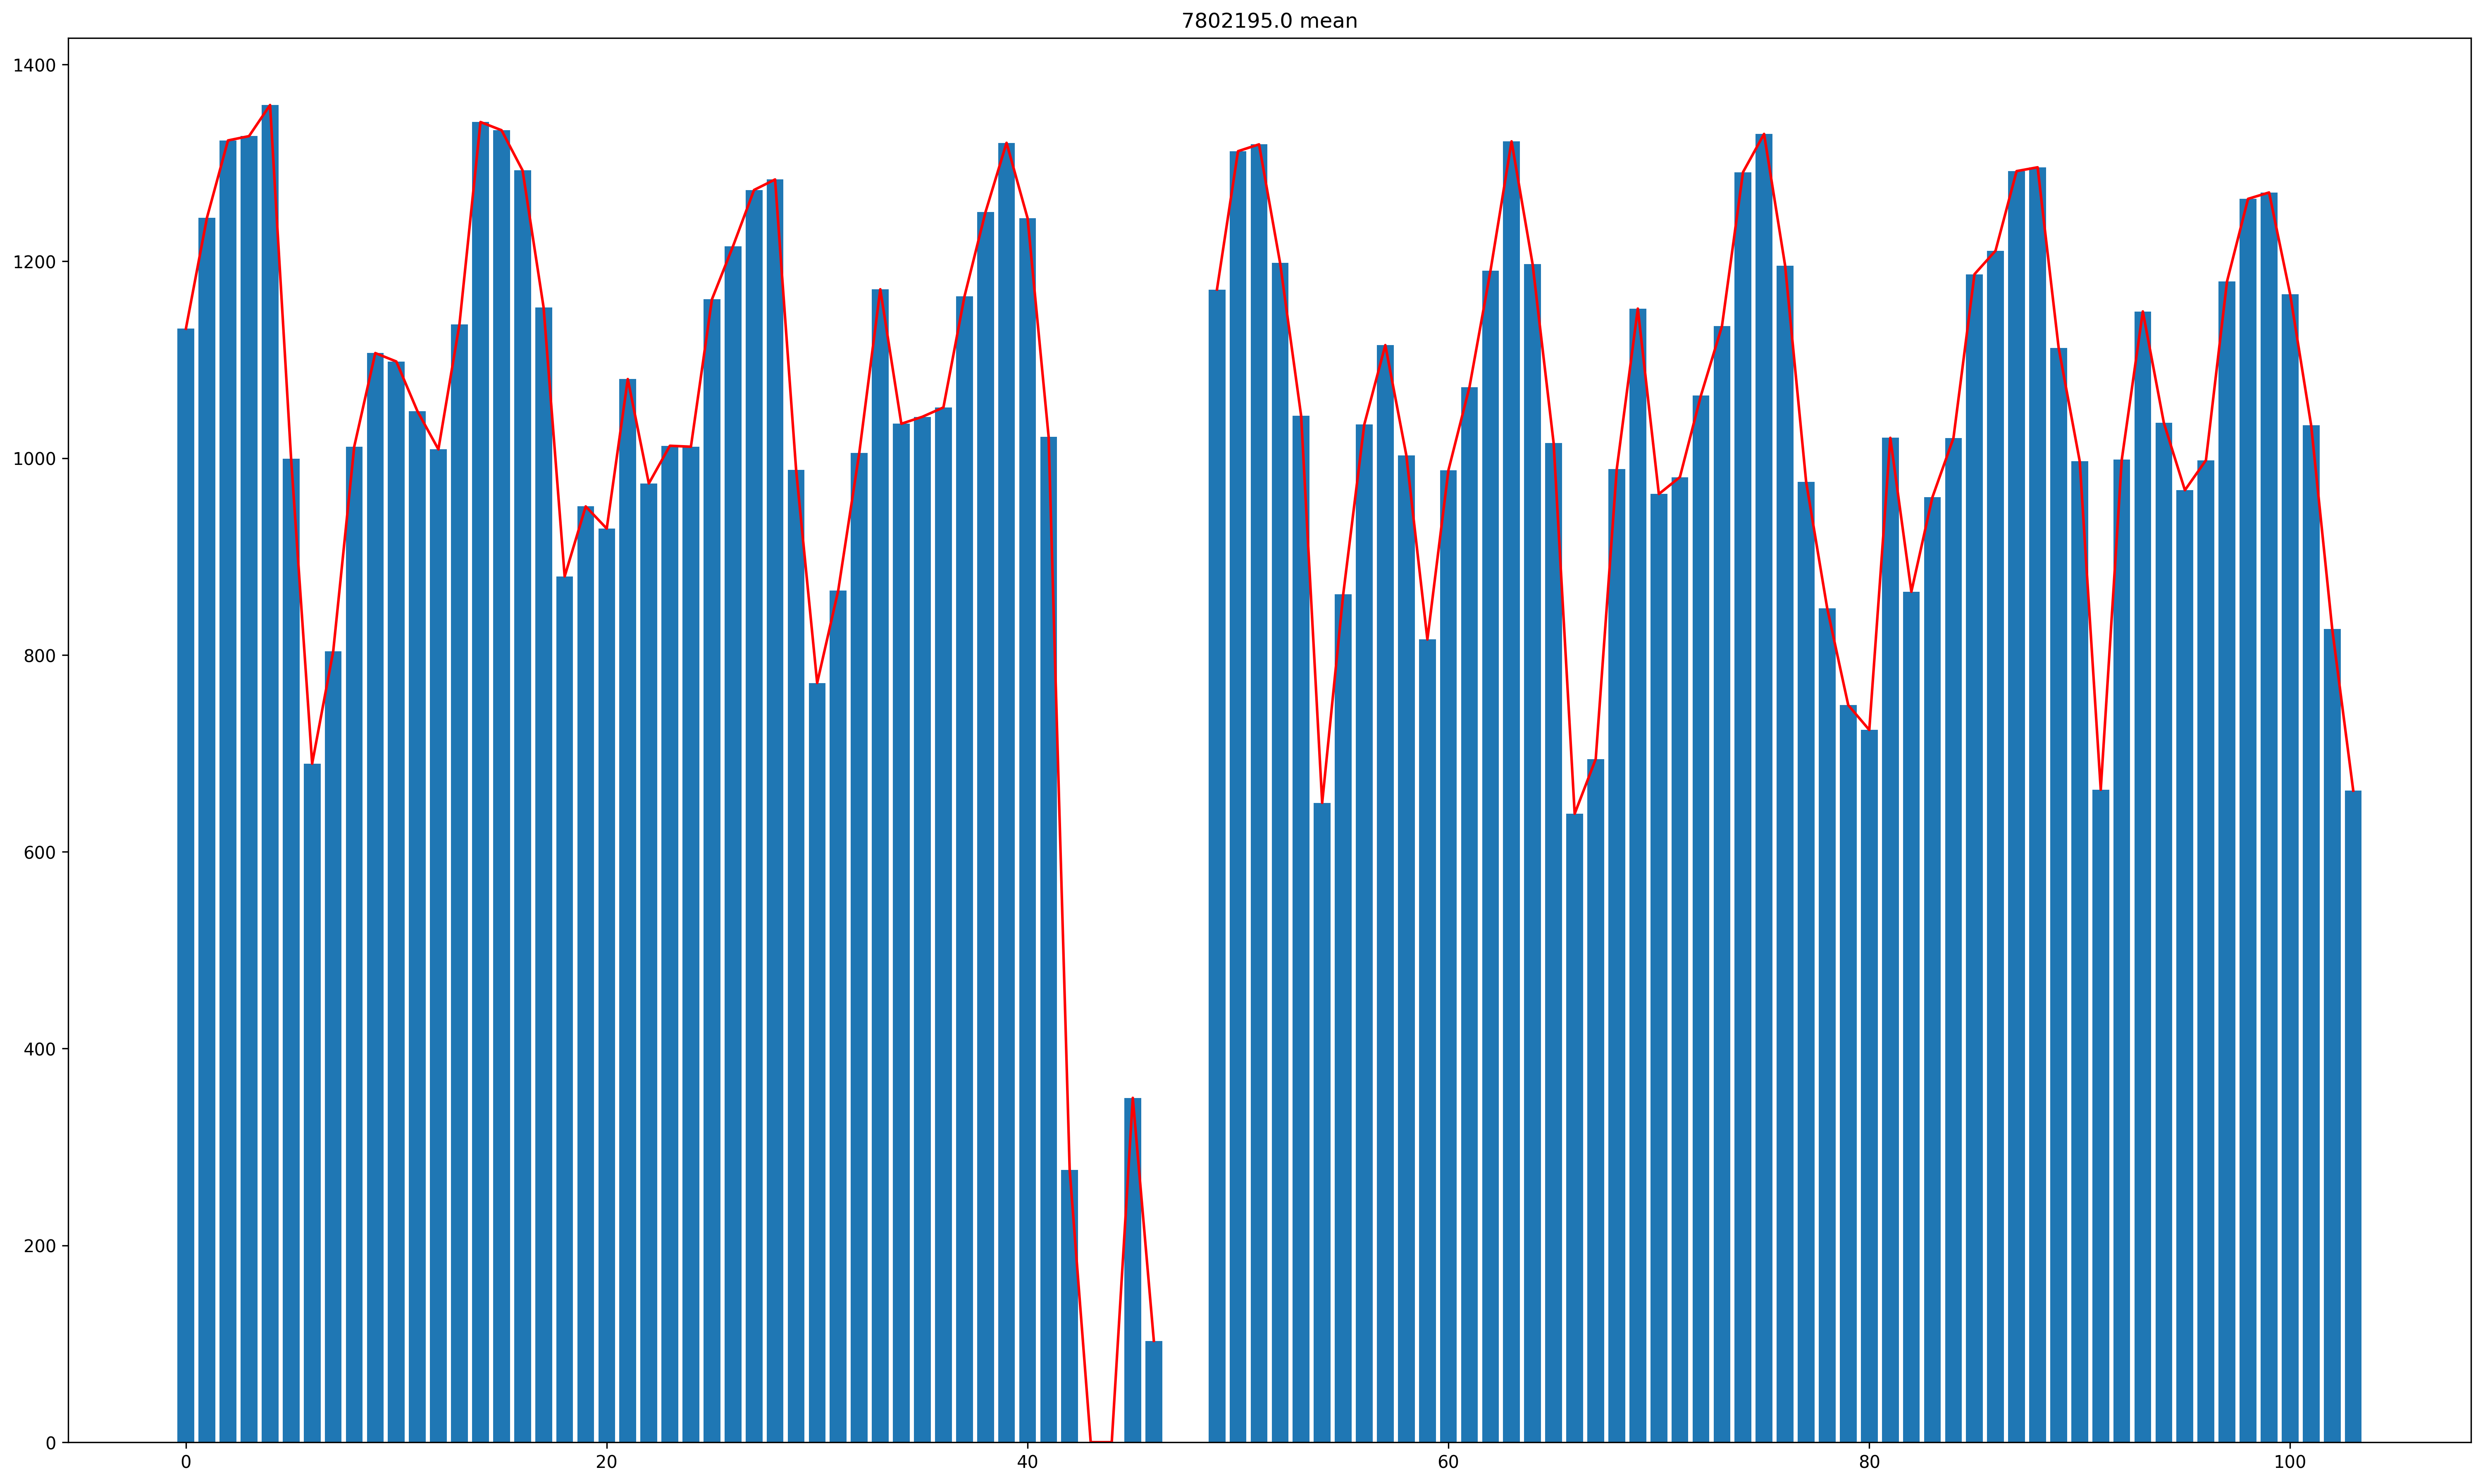

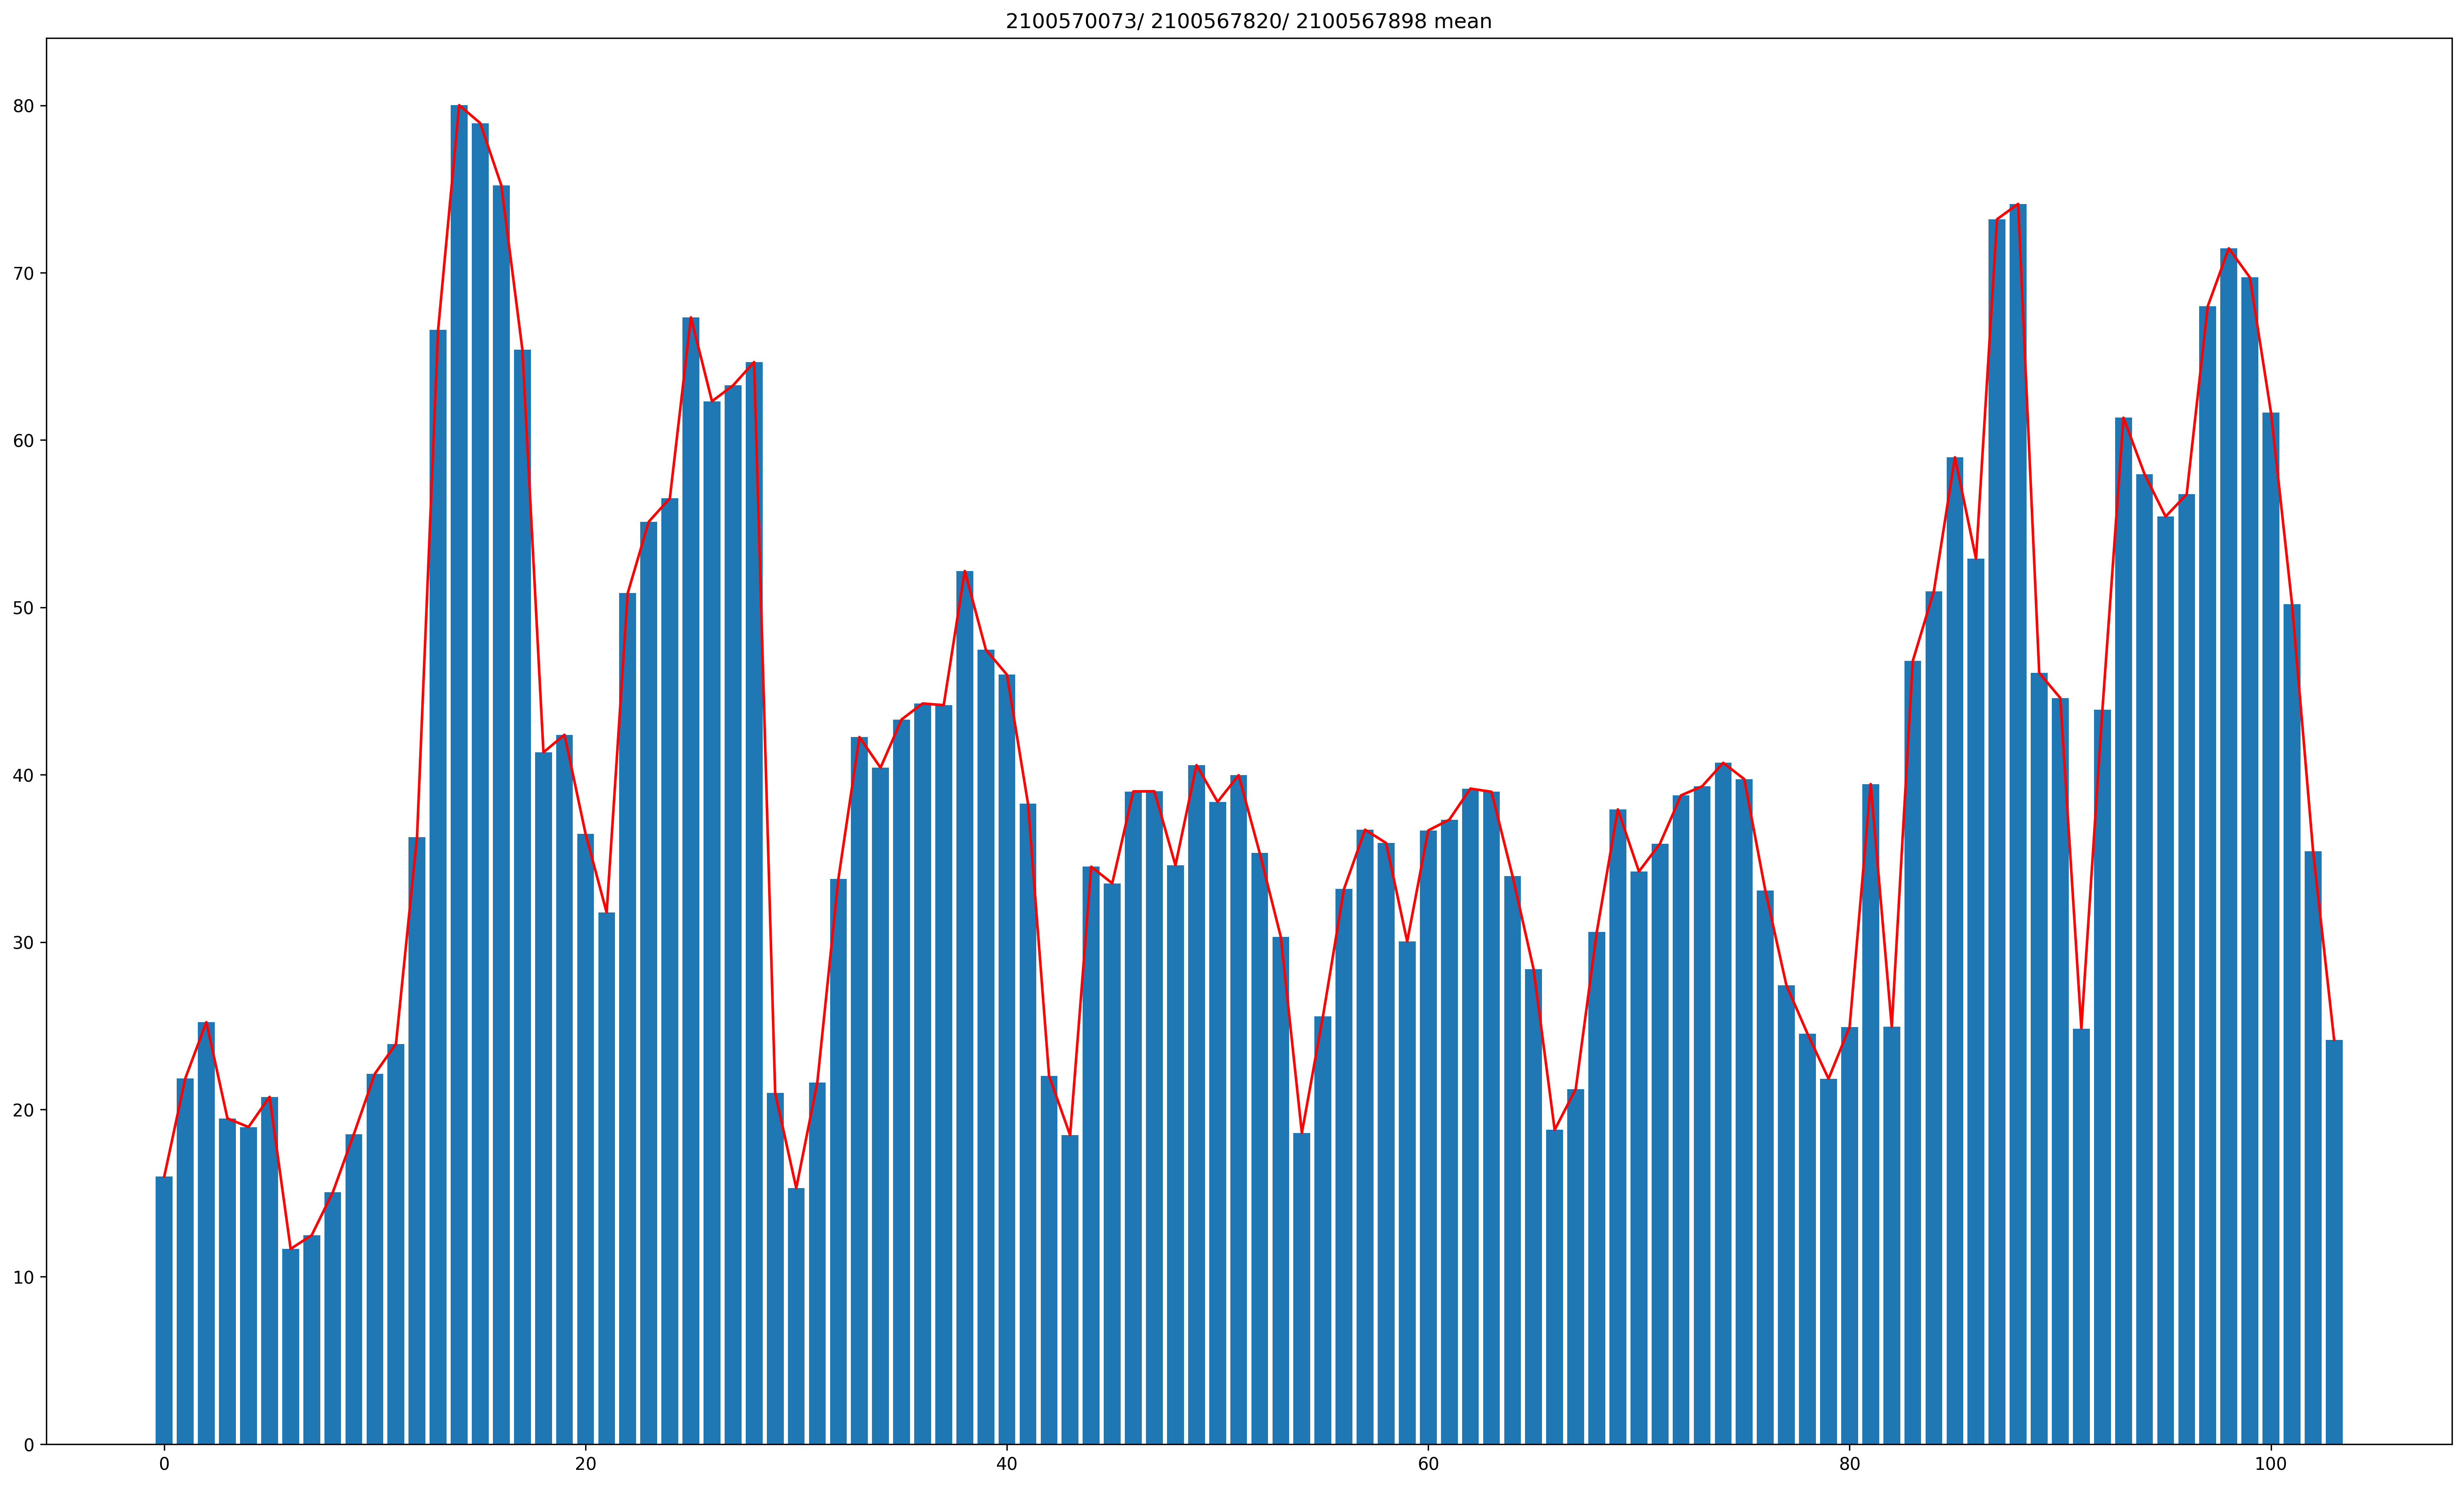

In [56]:
for module in modules:
    temp_module_data = []
#     print(month_list)
#     break
    for year in years:
        temp_module_data.extend(dict_mean[year][module])
#     print(len(month_list), len(mean_per_months[module]), len(temp_module_data))
#     print(type(month_list[0]))
    fig = plt.figure(figsize=(25,15), dpi=300)
#     print(mean_per_months[module])
#     print(month_list.shape, mean_per_months[module].shape)
    plt.bar(range(len(month_list)), temp_module_data)
    plt.plot(range(len(month_list)), temp_module_data, c='r')
    plt.title(module+" mean")
    plt.show()

## TIME SERIES

In [95]:
# df1 = df1.set_index('Date')

In [96]:
for i in df1.columns[1:]:
    print(i)
    temp = df1[i].value_counts().to_dict()
    print(temp)
    if 1.0 in temp.keys():
        df1[str(i)][df1[str(i)] == 1.0] = (temp[1.0]/100)**12

Grid Failure
{0: 1512, 1: 858}
Inverter
{0: 2127, 1: 243}
Module Cleaning
{0: 1573, 1: 797}
Rainy day
{0: 2326, 1: 44}
No Module Cleaning
{0: 2284, 1: 86}
Transformer replacement and maintenance
{0: 2351, 1: 19}
Cable and Fuse maintenance
{0: 2304, 1: 66}
Plant Shutdown
{0: 2369, 1: 1}
Internet
{0: 2310, 1: 60}
Battery
{0: 2343, 1: 27}
Cloudy
{0: 1969, 1: 401}
Module Cleaning by rains
{0: 2370}


/var/folders/4r/3pd1tn_x59n48w85hg2nw0zm0000gn/T/ipykernel_9174/3028890833.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[str(i)][df1[str(i)] == 1.0] = (temp[1.0]/100)**12
/var/folders/4r/3pd1tn_x59n48w85hg2nw0zm0000gn/T/ipykernel_9174/3028890833.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[str(i)][df1[str(i)] == 1.0] = (temp[1.0]/100)**12
/var/folders/4r/3pd1tn_x59n48w85hg2nw0zm0000gn/T/ipykernel_9174/3028890833.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

In [97]:
df1.head()

Total Generation (KWH)  Grid Failure      Inverter  \
Date                                                             
2012-07-06                  3218.0  1.591650e+11      0.000000   
2012-07-07                  3633.0  1.591650e+11      0.000000   
2012-07-08                  4377.0  0.000000e+00  42391.158275   
2012-07-09                  4625.0  0.000000e+00  42391.158275   
2012-07-10                   648.0  0.000000e+00  42391.158275   

            Module Cleaning  Rainy day  No Module Cleaning  \
Date                                                         
2012-07-06              0.0        0.0                 0.0   
2012-07-07              0.0        0.0                 0.0   
2012-07-08              0.0        0.0                 0.0   
2012-07-09              0.0        0.0                 0.0   
2012-07-10              0.0        0.0                 0.0   

            Transformer replacement and maintenance  \
Date                                                  
2012-07-06                                      0.0   
2012-07-07                                      0.0   
2012-07-08                                      0.0   
2012-07-09                                      0.0   
2012-07-10                                      0.0   

            Cable and Fuse maintenance  Plant Shutdown  Internet  Battery  \
Date                                                                        
2012-07-06                         0.0             0.0       0.0      0.0   
2012-07-07                         0.0             0.0       0.0      0.0   
2012-07-08                         0.0             0.0       0.0      0.0   
2012-07-09                         0.0             0.0       0.0      0.0   
2012-07-10                         0.0             0.0       0.0      0.0   

            Cloudy  Module Cleaning by rains  
Date                                          
2012-07-06     0.0                         0  
2012-07-07     0.0                         0  
2012-07-08     0.0                         0  
2012-07-09     0.0                         0  
2012-07-10     0.0                         0

In [98]:
df1['Total Generation (KWH)'] = pd.to_numeric(df1['Total Generation (KWH)'])
df1['Total Generation (KWH)'].dtype

dtype('float64')

In [99]:
corr_df = df1.corr()
# corr_df[corr_df < 0] = 0
corr_df

Total Generation (KWH)  Grid Failure  \
Total Generation (KWH)                                 1.000000     -0.130600   
Grid Failure                                          -0.130600      1.000000   
Inverter                                              -0.314601      0.057966   
Module Cleaning                                        0.128121      0.028741   
Rainy day                                             -0.243720      0.006965   
No Module Cleaning                                    -0.005216     -0.071054   
Transformer replacement and maintenance               -0.050500     -0.008649   
Cable and Fuse maintenance                             0.032419     -0.004769   
Plant Shutdown                                         0.014604      0.027274   
Internet                                               0.058770      0.007146   
Battery                                               -0.042502     -0.006409   
Cloudy                                                -0.430203     -0.026162   
Module Cleaning by rains                                    NaN           NaN   

                                         Inverter  Module Cleaning  Rainy day  \
Total Generation (KWH)                  -0.314601         0.128121  -0.243720   
Grid Failure                             0.057966         0.028741   0.006965   
Inverter                                 1.000000        -0.240594   0.345086   
Module Cleaning                         -0.240594         1.000000  -0.097901   
Rainy day                                0.345086        -0.097901   1.000000   
No Module Cleaning                      -0.065587        -0.138123  -0.026688   
Transformer replacement and maintenance  0.047602         0.046175   0.022688   
Cable and Fuse maintenance              -0.057207         0.036938  -0.004281   
Plant Shutdown                          -0.006944         0.028864  -0.002826   
Internet                                -0.045619        -0.103348  -0.022166   
Battery                                  0.107890        -0.076412  -0.014764   
Cloudy                                   0.170230        -0.206888   0.304770   
Module Cleaning by rains                      NaN              NaN        NaN   

                                         No Module Cleaning  \
Total Generation (KWH)                            -0.005216   
Grid Failure                                      -0.071054   
Inverter                                          -0.065587   
Module Cleaning                                   -0.138123   
Rainy day                                         -0.026688   
No Module Cleaning                                 1.000000   
Transformer replacement and maintenance           -0.017444   
Cable and Fuse maintenance                         0.008297   
Plant Shutdown                                    -0.003987   
Internet                                          -0.031273   
Battery                                           -0.020830   
Cloudy                                             0.032792   
Module Cleaning by rains                                NaN   

                                         Transformer replacement and maintenance  \
Total Generation (KWH)                                                 -0.050500   
Grid Failure                                                           -0.008649   
Inverter                                                                0.047602   
Module Cleaning                                                         0.046175   
Rainy day                                                               0.022688   
No Module Cleaning                                                     -0.017444   
Transformer replacement and maintenance                                 1.000000   
Cable and Fuse maintenance                                             -0.015215   
Plant Shutdown                                                         -0.001847   
Internet                                        

In [100]:
# total_0 = 0
# total_1 = 0
# for i in df1.columns[1:]:
#     value_c = df1[i].value_counts()
#     print(df1[i].value_counts())
#     total_0 += value_c[]

In [101]:
df1 = df1.drop(["Cable and Fuse maintenance","No Module Cleaning","Rainy day","Transformer replacement and maintenance","Plant Shutdown","Internet","Battery","Module Cleaning by rains"], axis=1)
df1

Total Generation (KWH)  Grid Failure      Inverter  \
Date                                                             
2012-07-06                 3218.00  1.591650e+11      0.000000   
2012-07-07                 3633.00  1.591650e+11      0.000000   
2012-07-08                 4377.00  0.000000e+00  42391.158275   
2012-07-09                 4625.00  0.000000e+00  42391.158275   
2012-07-10                  648.00  0.000000e+00  42391.158275   
...                            ...           ...           ...   
2018-12-27                 4129.29  1.591650e+11      0.000000   
2018-12-28                 4266.50  0.000000e+00      0.000000   
2018-12-29                 3732.03  1.591650e+11      0.000000   
2018-12-30                 4063.88  0.000000e+00  42391.158275   
2018-12-31                 4093.90  1.591650e+11      0.000000   

            Module Cleaning  Cloudy  
Date                                 
2012-07-06     0.000000e+00     0.0  
2012-07-07     0.000000e+00     0.0  
2012-07-08     0.000000e+00     0.0  
2012-07-09     0.000000e+00     0.0  
2012-07-10     0.000000e+00     0.0  
...                     ...     ...  
2018-12-27     6.569009e+10     0.0  
2018-12-28     6.569009e+10     0.0  
2018-12-29     6.569009e+10     0.0  
2018-12-30     0.000000e+00     0.0  
2018-12-31     6.569009e+10     0.0  

[2370 rows x 5 columns]

In [132]:
df_prob['2013']

NameError: name 'df_prob' is not defined

In [122]:
def model_function(df1):

    print(df1.tail(8))
    endog_array = df1.to_numpy(dtype=int)
    var_model = VAR(endog_array)

#     print(var_model.select_order(48).summary())

    results = var_model.fit(15, trend='c', ic='aic')
#     print(results.summary())

    lag = results.k_ar
    forecast_results = results.forecast(df1.values[-lag:],steps=forecast_days)
    
    return forecast_results

In [123]:
columns = list(df1.columns)

In [104]:
columns

['Total Generation (KWH)',
 'Grid Failure',
 'Inverter',
 'Module Cleaning',
 'Cloudy']

In [105]:
final_train_df = df1.copy()

In [106]:
date_list = pd.date_range(start="2019-01-01",end="2020-01-30")

In [107]:
date_list = pd.to_datetime(date_list)

In [108]:
date_list

DatetimeIndex(['2019-01-01', '2019-01-02', '2019-01-03', '2019-01-04',
               '2019-01-05', '2019-01-06', '2019-01-07', '2019-01-08',
               '2019-01-09', '2019-01-10',
               ...
               '2020-01-21', '2020-01-22', '2020-01-23', '2020-01-24',
               '2020-01-25', '2020-01-26', '2020-01-27', '2020-01-28',
               '2020-01-29', '2020-01-30'],
              dtype='datetime64[ns]', length=395, freq='D')

In [109]:
final_train_df

Total Generation (KWH)  Grid Failure      Inverter  \
Date                                                             
2012-07-06                 3218.00  1.591650e+11      0.000000   
2012-07-07                 3633.00  1.591650e+11      0.000000   
2012-07-08                 4377.00  0.000000e+00  42391.158275   
2012-07-09                 4625.00  0.000000e+00  42391.158275   
2012-07-10                  648.00  0.000000e+00  42391.158275   
...                            ...           ...           ...   
2018-12-27                 4129.29  1.591650e+11      0.000000   
2018-12-28                 4266.50  0.000000e+00      0.000000   
2018-12-29                 3732.03  1.591650e+11      0.000000   
2018-12-30                 4063.88  0.000000e+00  42391.158275   
2018-12-31                 4093.90  1.591650e+11      0.000000   

            Module Cleaning  Cloudy  
Date                                 
2012-07-06     0.000000e+00     0.0  
2012-07-07     0.000000e+00     0.0  
2012-07-08     0.000000e+00     0.0  
2012-07-09     0.000000e+00     0.0  
2012-07-10     0.000000e+00     0.0  
...                     ...     ...  
2018-12-27     6.569009e+10     0.0  
2018-12-28     6.569009e+10     0.0  
2018-12-29     6.569009e+10     0.0  
2018-12-30     0.000000e+00     0.0  
2018-12-31     6.569009e+10     0.0  

[2370 rows x 5 columns]

In [110]:
date_list[7*0:7*(0+1)]

DatetimeIndex(['2019-01-01', '2019-01-02', '2019-01-03', '2019-01-04',
               '2019-01-05', '2019-01-06', '2019-01-07'],
              dtype='datetime64[ns]', freq='D')

In [125]:
final_result_df = pd.DataFrame()
final_train_df = df1.copy()
# for loop for updating results in for loop
# append the result dictionary to training dictionary
# try to predict n times for 7 days to remove linear result
# as we are expecting that our former prediction is near to perfect to create offset
for i in range(4):
    print("Times run:",i+1)
    temp_result = model_function(final_train_df)
    temp_result = pd.DataFrame(temp_result, columns=columns)
    final_result_df = final_result_df.append(temp_result, ignore_index=True)
    temp_result['Date'] = date_list[7*i:7*(i+1)]
    temp_result = temp_result.set_index('Date')
    final_train_df = final_train_df.append(temp_result)
#     print(final_train_df.tail(8))

Times run: 1
            Total Generation (KWH)  Grid Failure      Inverter  \
Date                                                             
2018-12-24                 2923.51  1.591650e+11      0.000000   
2018-12-25                 3970.89  0.000000e+00      0.000000   
2018-12-26                 4012.14  0.000000e+00      0.000000   
2018-12-27                 4129.29  1.591650e+11      0.000000   
2018-12-28                 4266.50  0.000000e+00      0.000000   
2018-12-29                 3732.03  1.591650e+11      0.000000   
2018-12-30                 4063.88  0.000000e+00  42391.158275   
2018-12-31                 4093.90  1.591650e+11      0.000000   

            Module Cleaning  Cloudy  
Date                                 
2018-12-24     6.569009e+10     0.0  
2018-12-25     6.569009e+10     0.0  
2018-12-26     6.569009e+10     0.0  
2018-12-27     6.569009e+10     0.0  
2018-12-28     6.569009e+10     0.0  
2018-12-29     6.569009e+10     0.0  
2018-12-30     0.00000

In [126]:
final_result_df['Date'] = date_list[:28]
final_result_df = final_result_df.set_index('Date')

In [127]:
final_result_df

Total Generation (KWH)  Grid Failure      Inverter  \
Date                                                             
2019-01-01             4006.415795  7.759326e+10   5683.410984   
2019-01-02             4018.499109  6.715480e+10   3163.837454   
2019-01-03             4176.961071  6.545419e+10   4804.110261   
2019-01-04             4119.504024  5.935420e+10   4443.525229   
2019-01-05             3921.924388  8.885053e+10   3362.763153   
2019-01-06             3916.175282  6.273029e+10  12704.775919   
2019-01-07             3903.286893  8.737411e+10   2705.088181   
2019-01-08             3875.558453  7.268312e+10   6163.541503   
2019-01-09             4044.455511  5.397992e+10   5437.155657   
2019-01-10             3992.132010  5.990379e+10   3565.866392   
2019-01-11             3936.363728  7.792146e+10   6539.399142   
2019-01-12             3940.238820  8.531494e+10   2741.911813   
2019-01-13             3946.400260  7.091566e+10  11667.587481   
2019-01-14             3976.046663  5.931284e+10   3644.032437   
2019-01-15             3896.712705  7.477902e+10   6112.238714   
2019-01-16             3946.781954  6.530857e+10   5669.523501   
2019-01-17             3979.488479  6.533940e+10   4974.843866   
2019-01-18             3949.329657  6.785647e+10   6338.997391   
2019-01-19             3917.960935  7.204092e+10   3746.860519   
2019-01-20             3896.734565  6.575715e+10   8596.846730   
2019-01-21             3916.762986  6.732729e+10   3995.052641   
2019-01-22             3880.277498  6.828942e+10   5703.853297   
2019-01-23             3916.155737  6.403096e+10   5823.102655   
2019-01-24             3942.262983  6.258875e+10   5130.238747   
2019-01-25             3909.313642  6.741154e+10   6053.419359   
2019-01-26             3904.674737  7.041091e+10   4247.359473   
2019-01-27             3891.490962  6.571142e+10   7750.777992   
2019-01-28             3904.248627  6.492478e+10   4371.306079   

            Module Cleaning        Cloudy  
Date                                       
2019-01-01     6.037081e+10  2.306168e+05  
2019-01-02     6.166103e+10 -3.550643e+05  
2019-01-03     6.070473e+10 -1.041128e+05  
2019-01-04     5.803120e+10 -2.813087e+04  
2019-01-05     6.195651e+10  1.093684e+05  
2019-01-06     1.770407e+10  4.742693e+05  
2019-01-07     6.479200e+10  5.890238e+05  
2019-01-08     5.412861e+10  1.282644e+06  
2019-01-09     5.491604e+10  5.805815e+05  
2019-01-10     5.586323e+10  7.564708e+05  
2019-01-11     4.920844e+10  1.078622e+06  
2019-01-12     5.691367e+10  8.890500e+05  
2019-01-13     1.995571e+10  8.242184e+05  
2019-01-14     5.928568e+10  1.150400e+06  
2019-01-15     4.948236e+10  1.266331e+06  
2019-01-16     4.992104e+10  1.097949e+06  
2019-01-17     5.105459e+10  1.040373e+06  
2019-01-18     4.643720e+10  1.175024e+06  
2019-01-19     5.351079e+10  1.228916e+06  
2019-01-20     2.580511e+10  1.331633e+06  
2019-01-21     5.588727e+10  1.543032e+06  
2019-01-22     4.627983e+10  1.552994e+06  
2019-01-23     4.631550e+10  1.583945e+06  
2019-01-24     4.768504e+10  1.516516e+06  
2019-01-25     4.290118e+10  1.618690e+06  
2019-01-26     4.970249e+10  1.640956e+06  
2019-01-27     2.744274e+10  1.735453e+06  
2019-01-28     5.174995e+10  1.844037e+06

In [128]:
# df_obj['2019'] = df_obj['2019'].set_index('Date')

KeyError: "None of ['Date'] are in the columns"

In [129]:
df_obj['2019']['Total Generation (KWH)'][0:28]

Date
2019-01-01    3812.94
2019-01-02    3920.74
2019-01-03    4113.45
2019-01-04    3873.59
2019-01-05    3603.61
2019-01-06    4401.37
2019-01-07    3852.56
2019-01-08    3913.55
2019-01-09    3731.08
2019-01-10    4058.75
2019-01-11    4077.43
2019-01-12    3923.99
2019-01-13    3544.94
2019-01-14    3184.01
2019-01-15    3738.13
2019-01-16    4121.14
2019-01-17    4013.75
2019-01-18    4207.29
2019-01-19    4375.61
2019-01-20    3834.01
2019-01-21    3557.79
2019-01-22    3701.02
2019-01-23    3823.90
2019-01-24    4342.60
2019-01-25    4370.45
2019-01-26    4540.54
2019-01-27    4629.45
2019-01-28    4412.47
Name: Total Generation (KWH), dtype: float64

In [130]:
graph_df = pd.DataFrame()
graph_df['Prediction'] = final_result_df['Total Generation (KWH)']
graph_df['Original'] = df_obj['2019']['Total Generation (KWH)'][:28]

In [131]:
graph_df

Prediction  Original
Date                             
2019-01-01  4006.415795   3812.94
2019-01-02  4018.499109   3920.74
2019-01-03  4176.961071   4113.45
2019-01-04  4119.504024   3873.59
2019-01-05  3921.924388   3603.61
2019-01-06  3916.175282   4401.37
2019-01-07  3903.286893   3852.56
2019-01-08  3875.558453   3913.55
2019-01-09  4044.455511   3731.08
2019-01-10  3992.132010   4058.75
2019-01-11  3936.363728   4077.43
2019-01-12  3940.238820   3923.99
2019-01-13  3946.400260   3544.94
2019-01-14  3976.046663   3184.01
2019-01-15  3896.712705   3738.13
2019-01-16  3946.781954   4121.14
2019-01-17  3979.488479   4013.75
2019-01-18  3949.329657   4207.29
2019-01-19  3917.960935   4375.61
2019-01-20  3896.734565   3834.01
2019-01-21  3916.762986   3557.79
2019-01-22  3880.277498   3701.02
2019-01-23  3916.155737   3823.90
2019-01-24  3942.262983   4342.60
2019-01-25  3909.313642   4370.45
2019-01-26  3904.674737   4540.54
2019-01-27  3891.490962   4629.45
2019-01-28  3904.248627   4412.47

<AxesSubplot:xlabel='Date'>

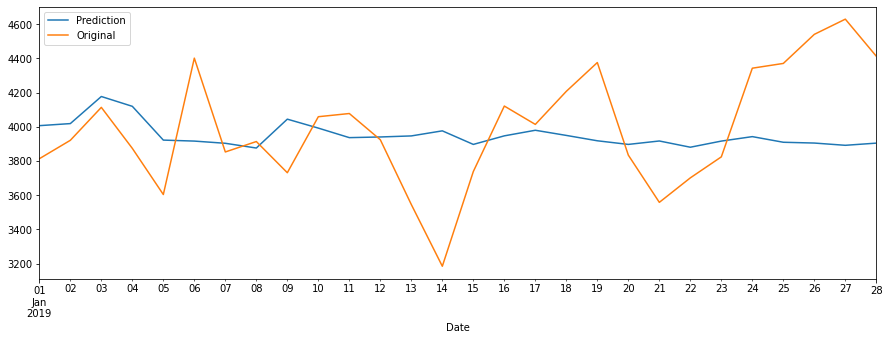

In [132]:
graph_df.plot(figsize=(15,5))

## Results

In [133]:
forecast_power = []
grid_pred = []
inverter_pred = []
module_pred = []
cloudy_pred = []
for i in forecast_results:
    forecast_power.append(i[0])
    grid_pred.append(i[1])
    inverter_pred.append(i[2])
    module_pred.append(i[3])
    cloudy_pred.append(i[4])

NameError: name 'forecast_results' is not defined

In [24]:
power_16 = df_obj['2019']['Total Generation (KWH)']
diff_power = pd.DataFrame({"Prediction":forecast_power[:forecast_days],"Original":power_16[:forecast_days],
                           "Grid_pred":grid_pred[:forecast_days],
                          "Module_pred":module_pred[:forecast_days],"Cloudy_pred":cloudy_pred[:forecast_days],
                          "Inverter_pred":inverter_pred[:forecast_days]})
diff_power['Difference'] = diff_power['Prediction'] - diff_power['Original']
diff_power

Prediction  Original     Grid_pred   Module_pred    Cloudy_pred  \
0  4006.415795   3812.94  7.759326e+10  6.037081e+10  230616.777479   
1  4018.499109   3920.74  6.715480e+10  6.166103e+10 -355064.259231   
2  4176.961071   4113.45  6.545419e+10  6.070473e+10 -104112.828160   
3  4119.504024   3873.59  5.935420e+10  5.803120e+10  -28130.869330   
4  3921.924388   3603.61  8.885053e+10  6.195651e+10  109368.449957   
5  3916.175282   4401.37  6.273029e+10  1.770407e+10  474269.305439   
6  3903.286893   3852.56  8.737411e+10  6.479200e+10  589023.846969   

   Inverter_pred  Difference  
0    5683.410984  193.475795  
1    3163.837454   97.759109  
2    4804.110261   63.511071  
3    4443.525229  245.914024  
4    3362.763153  318.314388  
5   12704.775919 -485.194718  
6    2705.088181   50.726893

## Plot results

<AxesSubplot:>

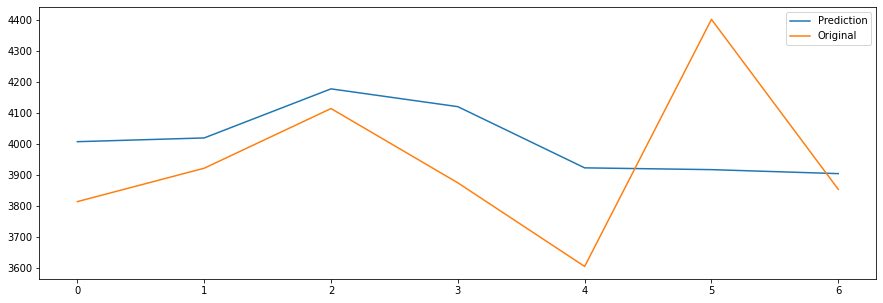

In [25]:
diff_power.plot(y=['Prediction','Original'],figsize=(15,5))

In [26]:
mean_squared_error(power_16[:forecast_days],forecast_power)**(1/2)

253.77387886382024

In [27]:
mean_absolute_error(power_16[:forecast_days],forecast_power)

207.84228523195972